PROJET 7 OPENCLASSROOM : Implémentez un modèle de scoring

Votre mission
Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.
Construire un dashboard interactif à destination des gestionnaires de la relation client permettant d'interpréter les prédictions faites par le modèle, et d’améliorer la connaissance client des chargés de relation client.
Compétences évaluées
Utiliser un logiciel de version de code pour assurer l’intégration du modèle
Déployer un modèle via une API dans le Web
Réaliser un dashboard pour présenter son travail de modélisation
Rédiger une note méthodologique afin de communiquer sa démarche de modélisation
Présenter son travail de modélisation à l'oral

In [1]:
# Chargement des librairies de travail
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import lightgbm as lgb
from sklearn.impute import SimpleImputer
from sklearn.metrics import plot_confusion_matrix, classification_report, log_loss, \
    roc_curve, auc, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
from pickle import dump
import shap
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
%matplotlib inline
shap.initjs()

C:\Users\akabe\anaconda3\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\Users\akabe\anaconda3\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\Users\akabe\anaconda3\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


# Analyse des données

## Chargement des données

In [19]:
# Chargement des différents datasets
list_data = ["sample_submission", "application_train", "bureau_balance", "bureau",
             "previous_application", "credit_card_balance", "POS_CASH_balance", "installments_payments"]

for i in list_data:
    print(i+".csv")
    globals()[i] = pd.read_csv(i+".csv",sep= ',')

sample_submission.csv
application_train.csv
bureau_balance.csv
bureau.csv
previous_application.csv
credit_card_balance.csv
POS_CASH_balance.csv
installments_payments.csv


In [20]:
# Nombre de lignes et colonnes par table de données
for i in list_data:
    print("pour", i, ":", globals()[i].shape)

pour sample_submission : (48744, 2)
pour application_train : (307511, 122)
pour bureau_balance : (27299925, 3)
pour bureau : (1716428, 17)
pour previous_application : (1670214, 37)
pour credit_card_balance : (3840312, 23)
pour POS_CASH_balance : (10001358, 8)
pour installments_payments : (13605401, 8)


### affichage des 5 premieres lignes de chaque table et valeurs manquantes

In [5]:
# Tous les champs date doivent etre convertis en année
pd.set_option('display.max_columns', application_train .shape[1])
application_train.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   
2         135000.0   Unaccompanied          Working   
3         297000.0   Unaccompanied          Working   
4         513000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461           -637            -3648.0   
1                    0.003541      -16765          -1188            -1186.0   
2                    0.010032      -19046           -225            -4260.0   
3                    0.008019      -19005          -3039            -9833.0   
4                    0.028663      -19932          -3038            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   
2                 1           1           0        Laborers              1.0   
3                 1           0           0        Laborers              2.0   
4                 1           0           0      Core staff              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        

In [21]:
# Passage des valeurs des champs date en année
champs_date = ['DAYS_BIRTH','DAYS_EMPLOYED','DAYS_REGISTRATION','DAYS_ID_PUBLISH',
              'DAYS_LAST_PHONE_CHANGE']
application_train[champs_date]= round(application_train[champs_date]/-365)

In [7]:
# Suppression des lignes sans SK_ID_CURR
application_train.dropna(subset=['SK_ID_CURR'],inplace = True)
# Suppression des doublons de SK_ID_CURR qui l'identifiant client
application_train.drop_duplicates(subset=['SK_ID_CURR'],inplace = True)

In [8]:
pd.set_option('display.max_columns', sample_submission.shape[1])
sample_submission.head()

SK_ID_CURR  TARGET
0      100001     0.5
1      100005     0.5
2      100013     0.5
3      100028     0.5
4      100038     0.5

In [9]:
pd.set_option('display.max_columns', bureau_balance.shape[1])
bureau_balance.head()

SK_ID_BUREAU  MONTHS_BALANCE STATUS
0       5715448               0      C
1       5715448              -1      C
2       5715448              -2      C
3       5715448              -3      C
4       5715448              -4      C

In [51]:
pd.set_option('display.max_columns', bureau.shape[1])
bureau.head()
BUREAU = bureau.copy()

In [22]:
champs_date_bureau = ['DAYS_CREDIT','DAYS_CREDIT_ENDDATE','DAYS_ENDDATE_FACT','DAYS_CREDIT_UPDATE']
bureau[champs_date_bureau] = round(bureau[champs_date_bureau]/-365)

In [12]:
pd.set_option('display.max_columns', previous_application.shape[1])
previous_application.head()

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430          17145.0   
1     2802425      108129         Cash loans    25188.615         607500.0   
2     2523466      122040         Cash loans    15060.735         112500.0   
3     2819243      176158         Cash loans    47041.335         450000.0   
4     1784265      202054         Cash loans    31924.395         337500.0   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0               0.0          17145.0                   SATURDAY   
1    679671.0               NaN         607500.0                   THURSDAY   
2    136444.5               NaN         112500.0                    TUESDAY   
3    470790.0               NaN         450000.0                     MONDAY   
4    404055.0               NaN         337500.0                   THURSDAY   

   HOUR_APPR_PROCESS_START FLAG_LAST_APPL_PER_CONTRACT  \
0                       15                           Y   
1                       11                           Y   
2                       11                           Y   
3                        7                           Y   
4                        9                           Y   

   NFLAG_LAST_APPL_IN_DAY  RATE_DOWN_PAYMENT  RATE_INTEREST_PRIMARY  \
0                       1                0.0               0.182832   
1                       1                NaN                    NaN   
2                       1                NaN                    NaN   
3                       1                NaN                    NaN   
4                       1                NaN                    NaN   

   RATE_INTEREST_PRIVILEGED NAME_CASH_LOAN_PURPOSE NAME_CONTRACT_STATUS  \
0                  0.867336                    XAP             Approved   
1                       NaN                    XNA             Approved   
2                       NaN                    XNA             Approved   
3                       NaN                    XNA             Approved   
4                       NaN                Repairs              Refused   

   DAYS_DECISION      NAME_PAYMENT_TYPE CODE_REJECT_REASON  NAME_TYPE_SUITE  \
0            -73  Cash through the bank                XAP              NaN   
1           -164                    XNA                XAP    Unaccompanied   
2           -301  Cash through the bank                XAP  Spouse, partner   
3           -512  Cash through the bank                XAP              NaN   
4           -781  Cash through the bank                 HC              NaN   

  NAME_CLIENT_TYPE NAME_GOODS_CATEGORY NAME_PORTFOLIO NAME_PRODUCT_TYPE  \
0         Repeater              Mobile            POS               XNA   
1         Repeater                 XNA           Cash            x-sell   
2         Repeater                 XNA           Cash            x-sell   
3         Repeater                 XNA           Cash            x-sell   
4         Repeater                 XNA           Cash           walk-in   

              CHANNEL_TYPE  SELLERPLACE_AREA NAME_SELLER_INDUSTRY  \
0             Country-wide                35         Connectivity   
1           Contact center                -1                  XNA   
2  Credit and cash offices                -1                  XNA   
3  Credit and cash offices                -1                  XNA   
4  Credit and cash offices                -1                  XNA   

   CNT_PAYMENT NAME_YIELD_GROUP       PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  \
0         12.0           middle  POS mobile with interest            365243.0   
1         36.0       low_action          Cash X-Sell: low            365243.0   
2         12.0             high         Cash X-Sell: high            365243.0   
3         12.0           middle       Cash X-Sell: middle            365243.0   
4         24.0             high         Cash Street: high                 NaN   

   D

In [23]:
champs_date_previous = ['DAYS_DECISION','DAYS_FIRST_DRAWING','DAYS_FIRST_DUE',
                        'DAYS_LAST_DUE_1ST_VERSION','DAYS_LAST_DUE','DAYS_TERMINATION']
previous_application[champs_date_previous] = round(previous_application[champs_date_previous]/-365)

In [14]:
pd.set_option('display.max_columns',credit_card_balance.shape[1])
credit_card_balance.head()

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE  \
0     2562384      378907              -6       56.970   
1     2582071      363914              -1    63975.555   
2     1740877      371185              -7    31815.225   
3     1389973      337855              -4   236572.110   
4     1891521      126868              -1   453919.455   

   AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  \
0                   135000                       0.0                 877.5   
1                    45000                    2250.0                2250.0   
2                   450000                       0.0                   0.0   
3                   225000                    2250.0                2250.0   
4                   450000                       0.0               11547.0   

   AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  \
0                         0.0                     877.5   
1                         0.0                       0.0   
2                         0.0                       0.0   
3                         0.0                       0.0   
4                         0.0                   11547.0   

   AMT_INST_MIN_REGULARITY  AMT_PAYMENT_CURRENT  AMT_PAYMENT_TOTAL_CURRENT  \
0                 1700.325               1800.0                     1800.0   
1                 2250.000               2250.0                     2250.0   
2                 2250.000               2250.0                     2250.0   
3                11795.760              11925.0                    11925.0   
4                22924.890              27000.0                    27000.0   

   AMT_RECEIVABLE_PRINCIPAL  AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  \
0                     0.000          0.000                 0.000   
1                 60175.080      64875.555             64875.555   
2                 26926.425      31460.085             31460.085   
3                224949.285     233048.970            233048.970   
4                443044.395     453919.455            453919.455   

   CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  CNT_DRAWINGS_OTHER_CURRENT  \
0                       0.0                     1                         0.0   
1                       1.0                     1                         0.0   
2                       0.0                     0                         0.0   
3                       1.0                     1                         0.0   
4                       0.0                     1                         0.0   

   CNT_DRAWINGS_POS_CURRENT  CNT_INSTALMENT_MATURE_CUM NAME_CONTRACT_STATUS  \
0                       1.0                       35.0               Active   
1                       0.0                       69.0               Active   
2                       0.0                       30.0               Active   
3                       0.0                       10.0               Active   
4                       1.0                      101.0               Active   

   SK_DPD  SK_DPD_DEF  
0       0           0  
1       0           0  
2       0           0  
3       0           0  
4       0           0

In [15]:
pd.set_option('display.max_columns', POS_CASH_balance.shape[1])
POS_CASH_balance.head()

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0     1803195      182943             -31            48.0   
1     1715348      367990             -33            36.0   
2     1784872      397406             -32            12.0   
3     1903291      269225             -35            48.0   
4     2341044      334279             -35            36.0   

   CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                   45.0               Active       0           0  
1                   35.0               Active       0           0  
2                    9.0               Active       0           0  
3                   42.0               Active       0           0  
4                   35.0               Active       0           0

In [16]:
pd.set_option('display.max_columns', installments_payments.shape[1])
installments_payments.head()

SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  \
0     1054186      161674                     1.0                      6   
1     1330831      151639                     0.0                     34   
2     2085231      193053                     2.0                      1   
3     2452527      199697                     1.0                      3   
4     2714724      167756                     1.0                      2   

   DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  AMT_PAYMENT  
0          -1180.0             -1187.0        6948.360     6948.360  
1          -2156.0             -2156.0        1716.525     1716.525  
2            -63.0               -63.0       25425.000    25425.000  
3          -2418.0             -2426.0       24350.130    24350.130  
4          -1383.0             -1366.0        2165.040     2160.585

In [24]:
champs_date_payments = ['DAYS_INSTALMENT','DAYS_ENTRY_PAYMENT']
installments_payments[champs_date_payments] = round(installments_payments[champs_date_payments]/-365)

### Analyse univariée de la table principale Application_train


In [20]:
# Champs alphanumeriques 
# constat majeur : j'ai de nombreuses modalités pour les champs ORGANIZATION_TYPE (58) et Occupation_Type (18)
# je vais regarder en detail ces modalités à des fins de regroupements
for col in application_train.select_dtypes('object'):
    print(col, application_train[col].nunique())

NAME_CONTRACT_TYPE 2
CODE_GENDER 3
FLAG_OWN_CAR 2
FLAG_OWN_REALTY 2
NAME_TYPE_SUITE 7
NAME_INCOME_TYPE 8
NAME_EDUCATION_TYPE 5
NAME_FAMILY_STATUS 6
NAME_HOUSING_TYPE 6
OCCUPATION_TYPE 18
WEEKDAY_APPR_PROCESS_START 7
ORGANIZATION_TYPE 58
FONDKAPREMONT_MODE 4
HOUSETYPE_MODE 3
WALLSMATERIAL_MODE 7
EMERGENCYSTATE_MODE 2


In [21]:
# analyse du poids des modalités pour chaque champs
for col in application_train.select_dtypes('object'):
    print (f'les modalités du champs {col} sont :\n {round(application_train[col].value_counts(normalize=True)*100,1)}')

les modalités du champs NAME_CONTRACT_TYPE sont :
 Cash loans         90.5
Revolving loans     9.5
Name: NAME_CONTRACT_TYPE, dtype: float64
les modalités du champs CODE_GENDER sont :
 F      65.8
M      34.2
XNA     0.0
Name: CODE_GENDER, dtype: float64
les modalités du champs FLAG_OWN_CAR sont :
 N    66.0
Y    34.0
Name: FLAG_OWN_CAR, dtype: float64
les modalités du champs FLAG_OWN_REALTY sont :
 Y    69.4
N    30.6
Name: FLAG_OWN_REALTY, dtype: float64
les modalités du champs NAME_TYPE_SUITE sont :
 Unaccompanied      81.2
Family             13.1
Spouse, partner     3.7
Children            1.1
Other_B             0.6
Other_A             0.3
Group of people     0.1
Name: NAME_TYPE_SUITE, dtype: float64
les modalités du champs NAME_INCOME_TYPE sont :
 Working                 51.6
Commercial associate    23.3
Pensioner               18.0
State servant            7.1
Unemployed               0.0
Student                  0.0
Businessman              0.0
Maternity leave          0.0
Name:

In [22]:
for col in application_train.select_dtypes('object'):
    print (f'les modalités du champs {col} sont :\n {application_train[col].unique()}')

les modalités du champs NAME_CONTRACT_TYPE sont :
 ['Cash loans' 'Revolving loans']
les modalités du champs CODE_GENDER sont :
 ['M' 'F' 'XNA']
les modalités du champs FLAG_OWN_CAR sont :
 ['N' 'Y']
les modalités du champs FLAG_OWN_REALTY sont :
 ['Y' 'N']
les modalités du champs NAME_TYPE_SUITE sont :
 ['Unaccompanied' 'Family' 'Spouse, partner' 'Children' 'Other_A' nan
 'Other_B' 'Group of people']
les modalités du champs NAME_INCOME_TYPE sont :
 ['Working' 'State servant' 'Commercial associate' 'Pensioner' 'Unemployed'
 'Student' 'Businessman' 'Maternity leave']
les modalités du champs NAME_EDUCATION_TYPE sont :
 ['Secondary / secondary special' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
les modalités du champs NAME_FAMILY_STATUS sont :
 ['Single / not married' 'Married' 'Civil marriage' 'Widow' 'Separated'
 'Unknown']
les modalités du champs NAME_HOUSING_TYPE sont :
 ['House / apartment' 'Rented apartment' 'With parents'
 'Municipal apartment' 'Off

In [79]:
def without_hue(plot, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 15)
    plt.show()

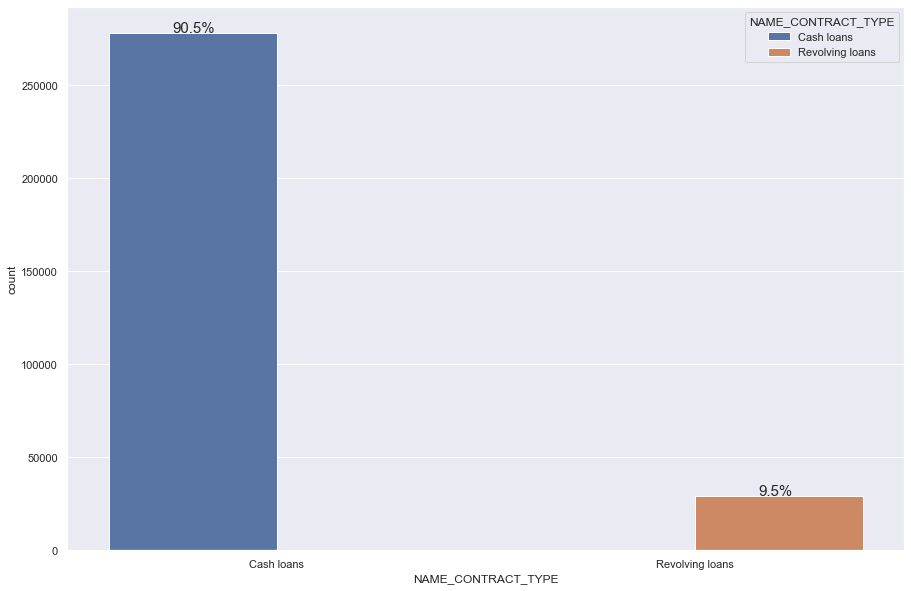

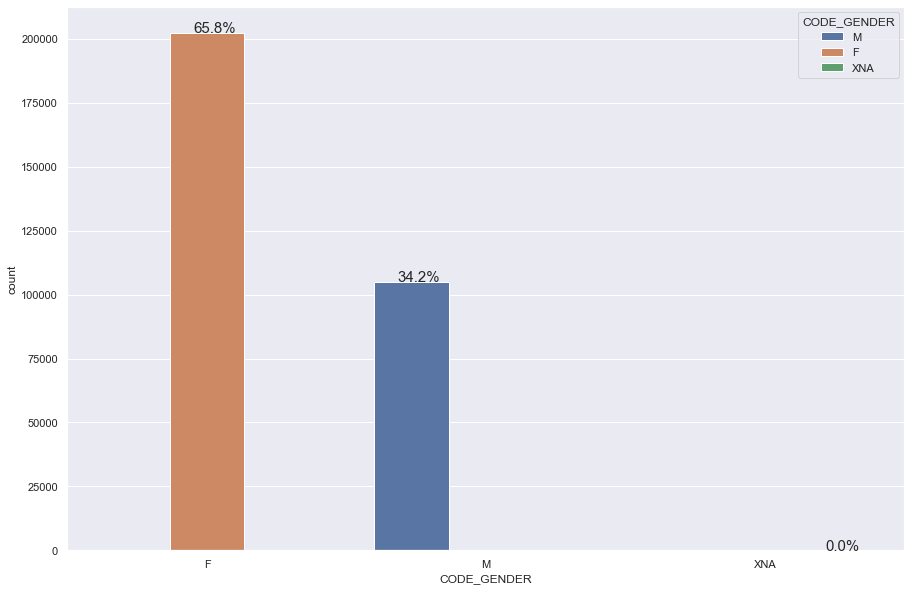

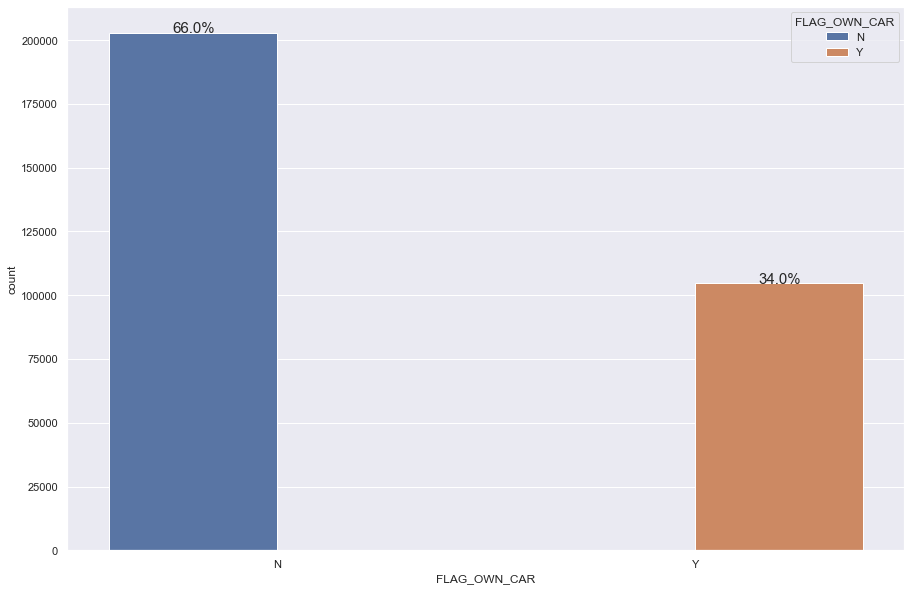

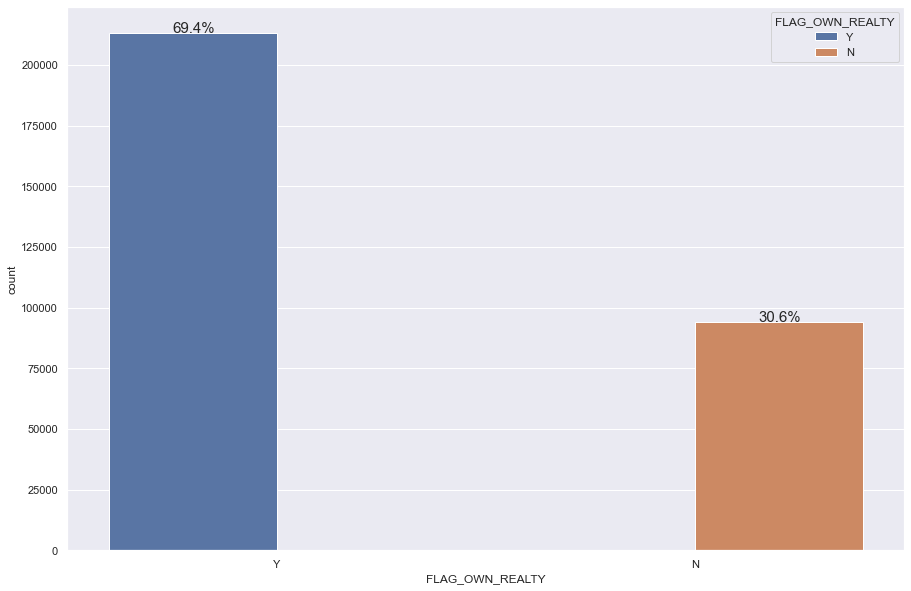

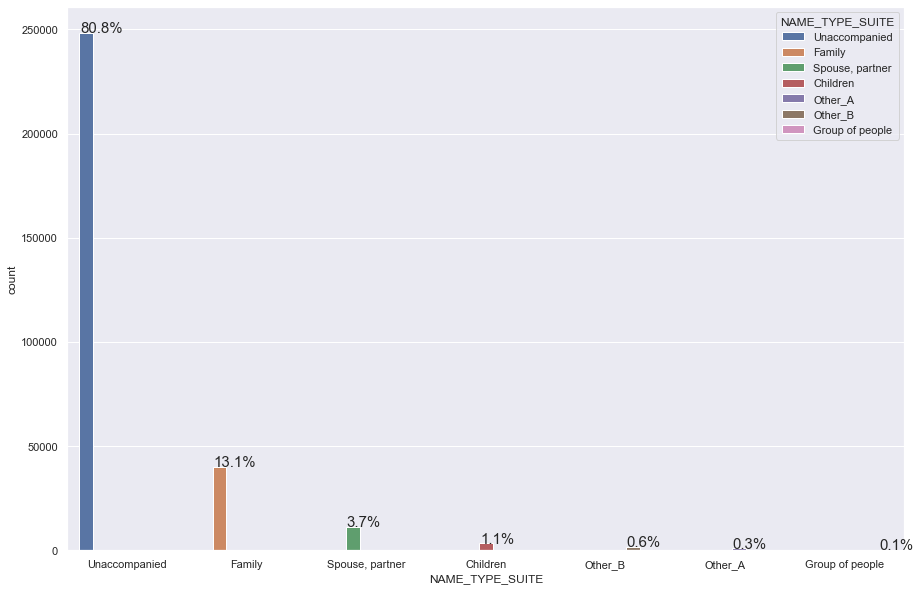

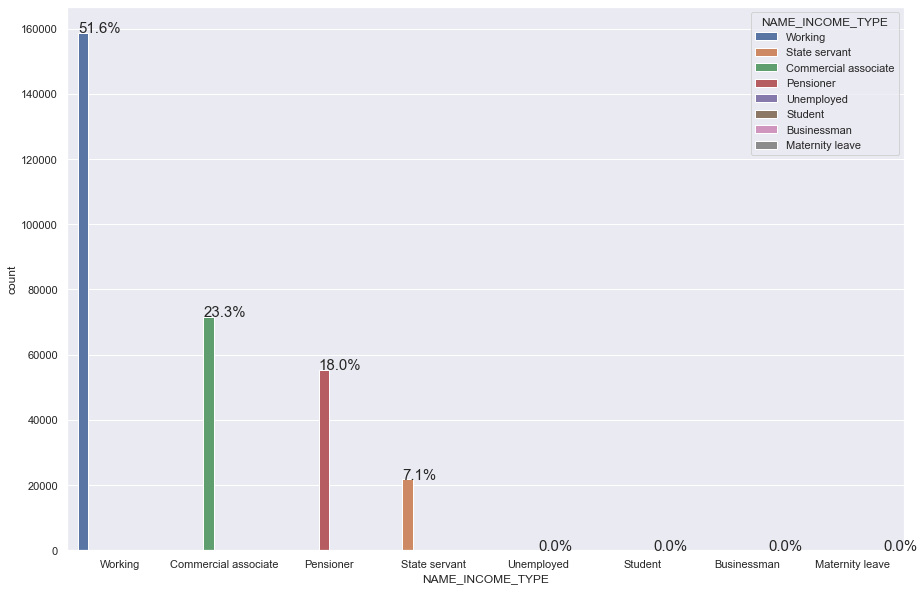

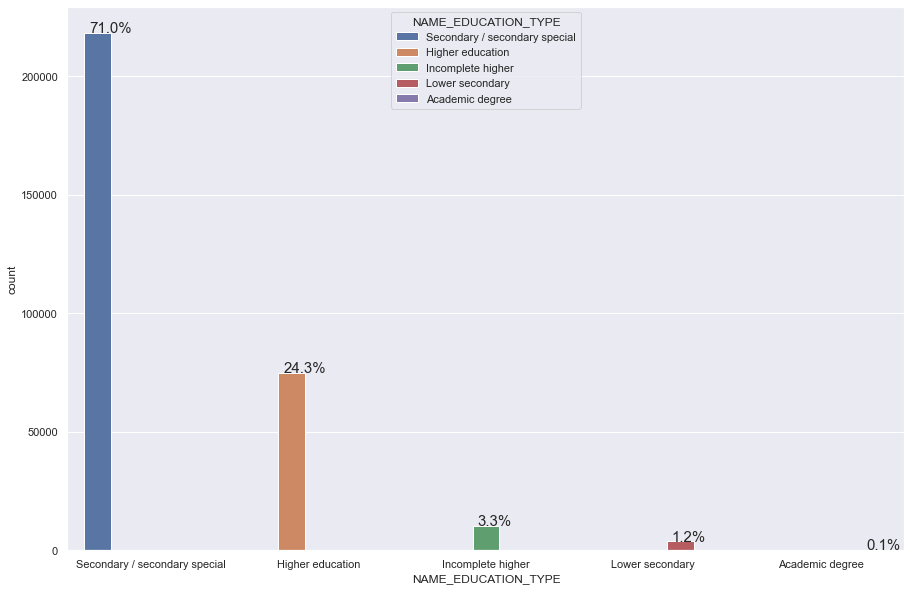

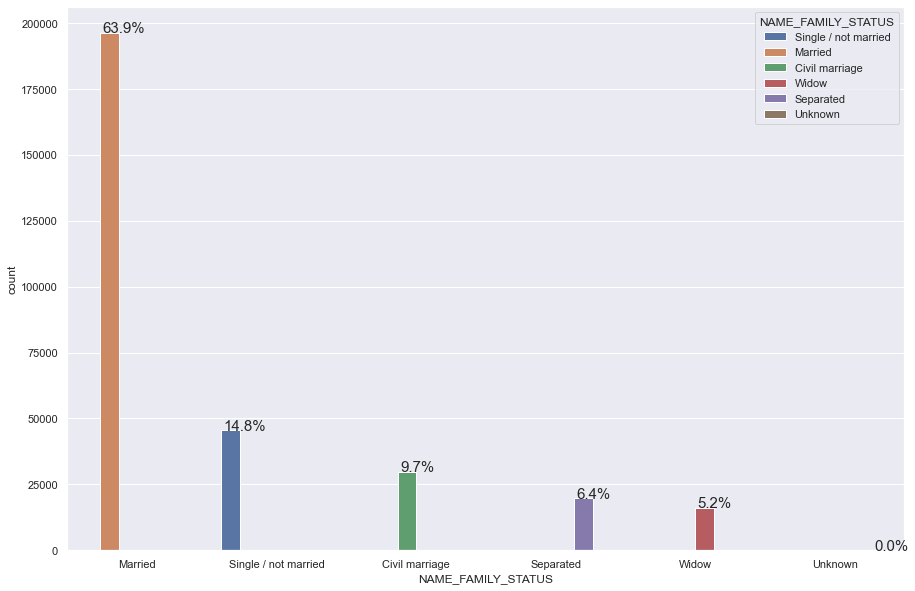

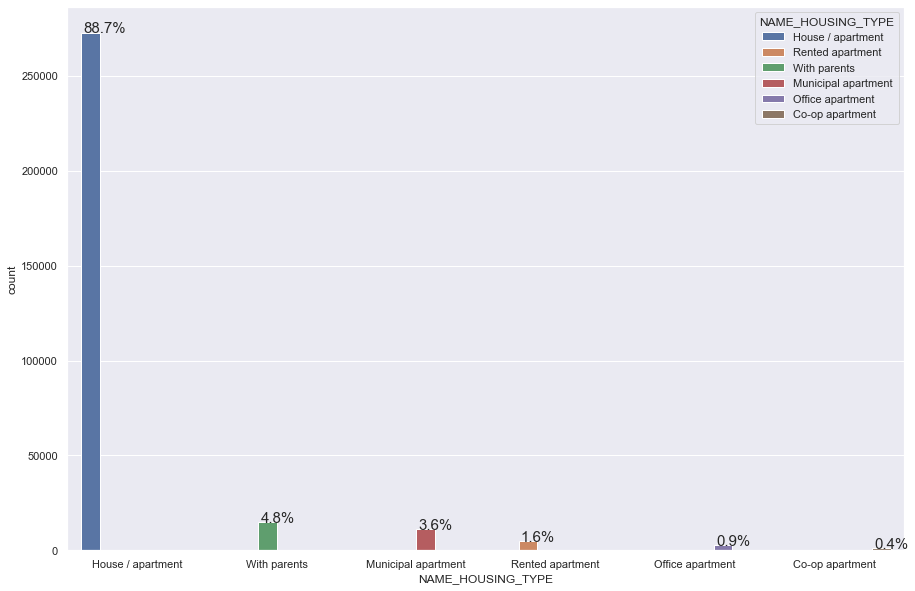

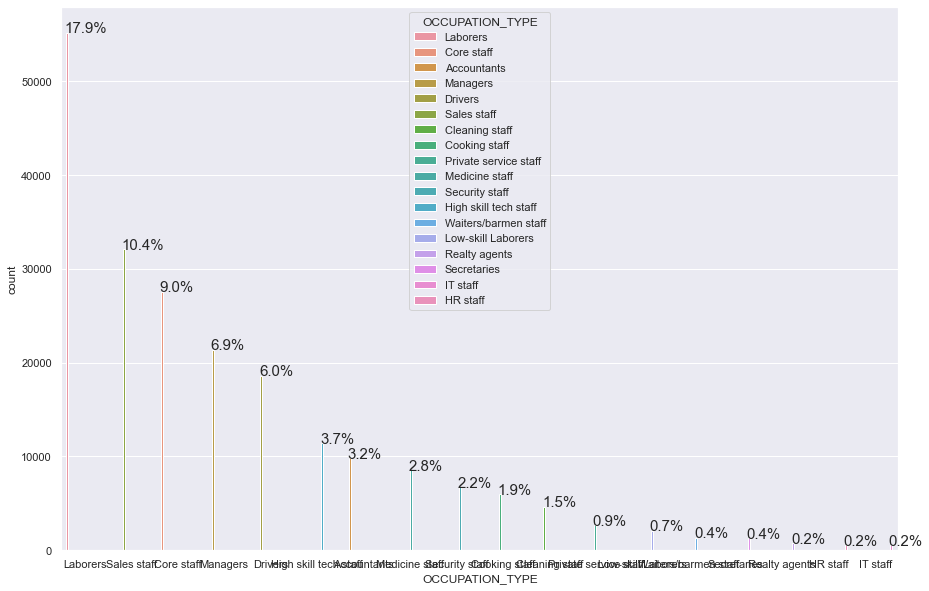

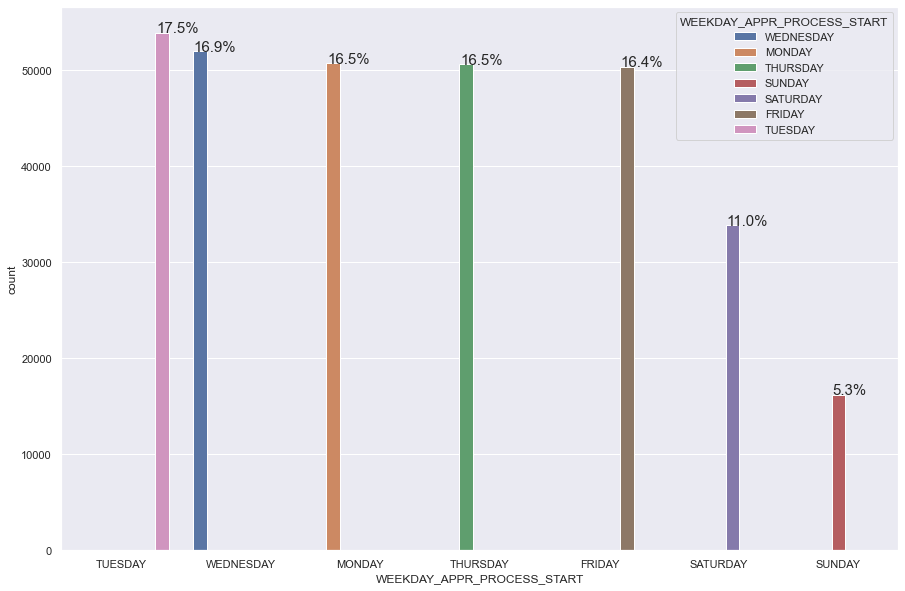

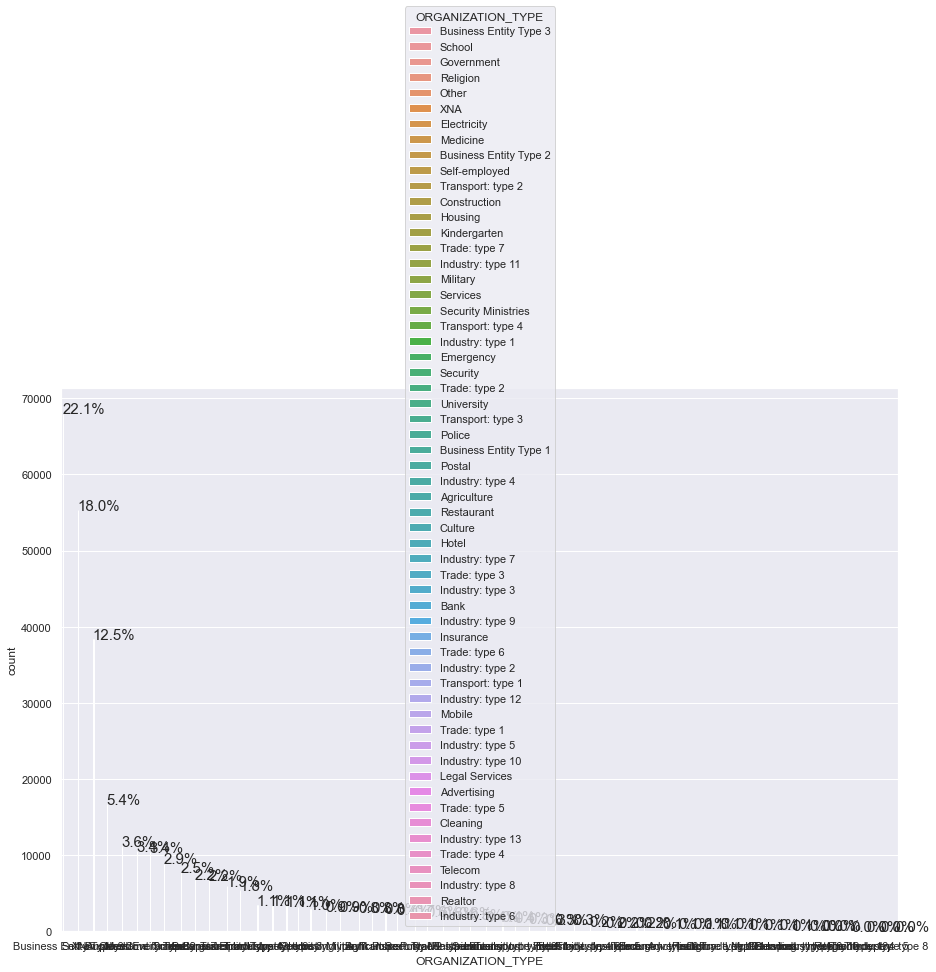

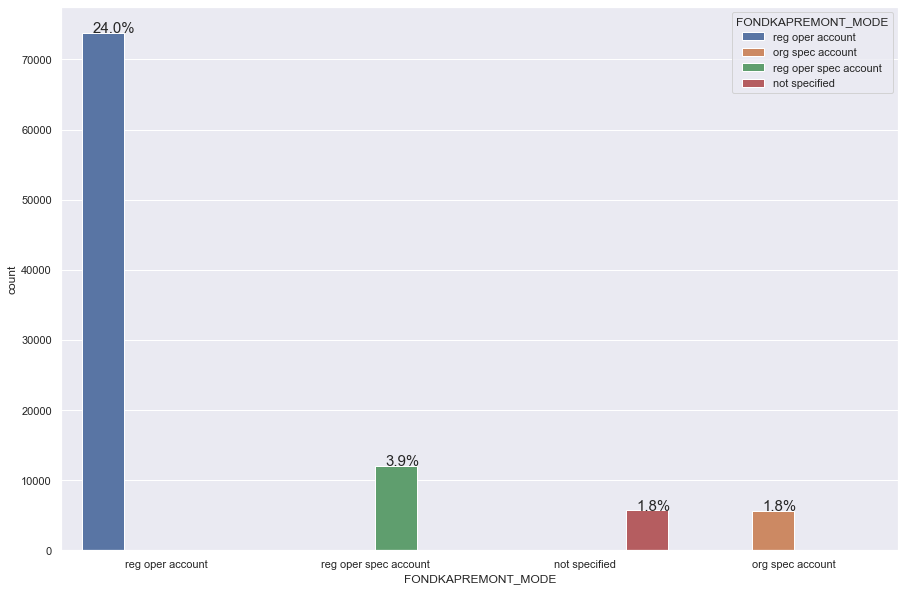

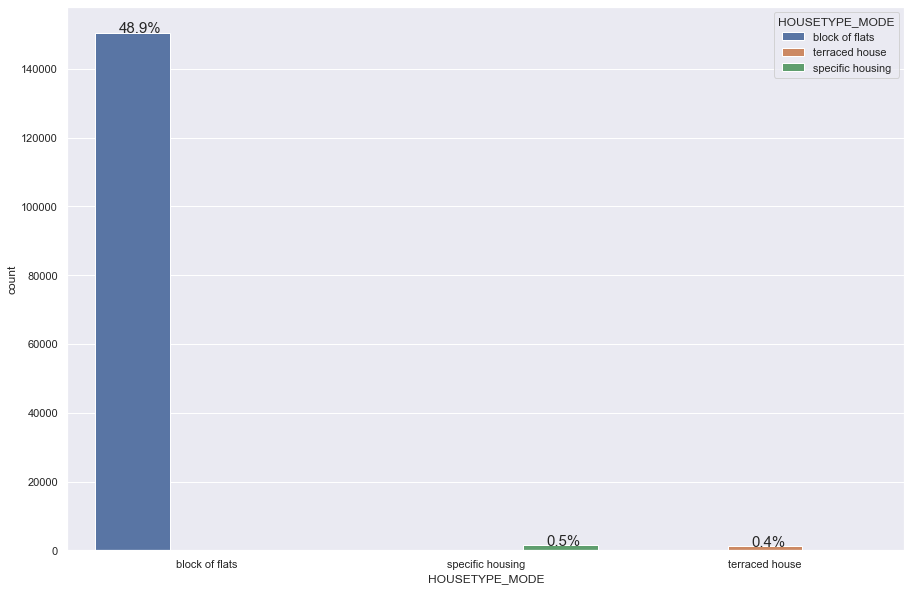

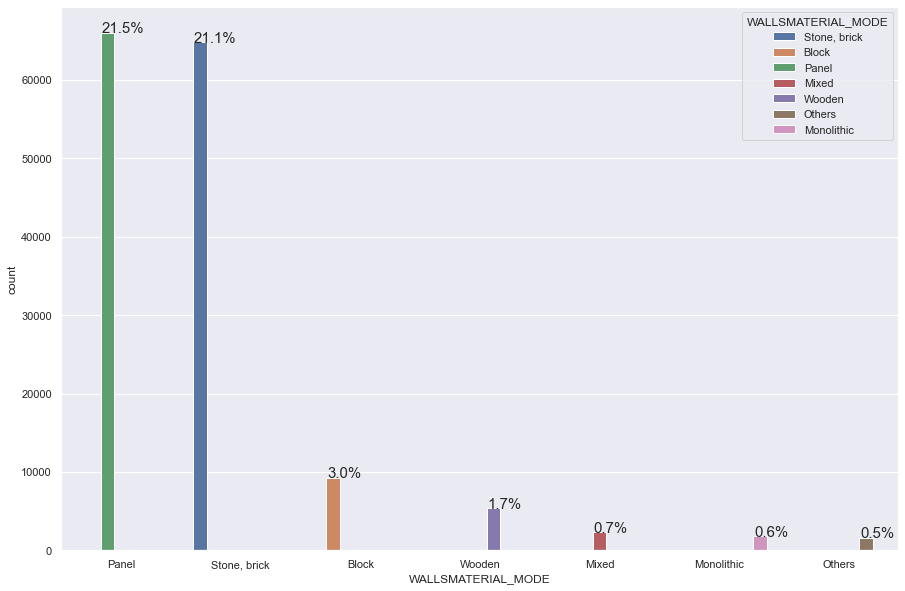

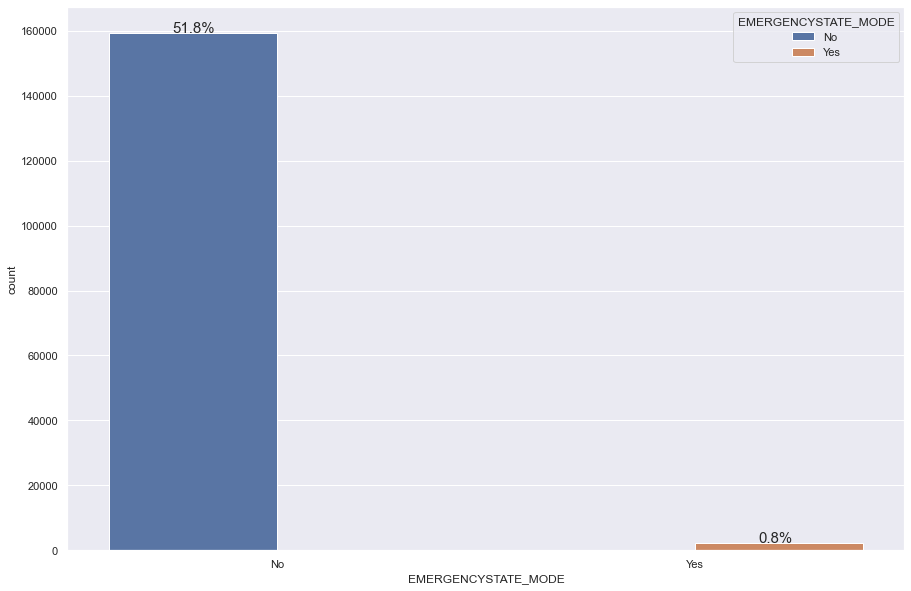

In [24]:
# Visualisation des champs alphanumeriques
for col in application_train.select_dtypes('object'):
    fig = plt.figure(figsize=(15,10))
    sns.set(style='darkgrid')
    #plt.title(col,fontsize=20)
    ax = sns.countplot(x =col, 
                  data=application_train,hue=application_train[col],
                  order = application_train[col].value_counts().index)
    without_hue(ax, application_train[col])

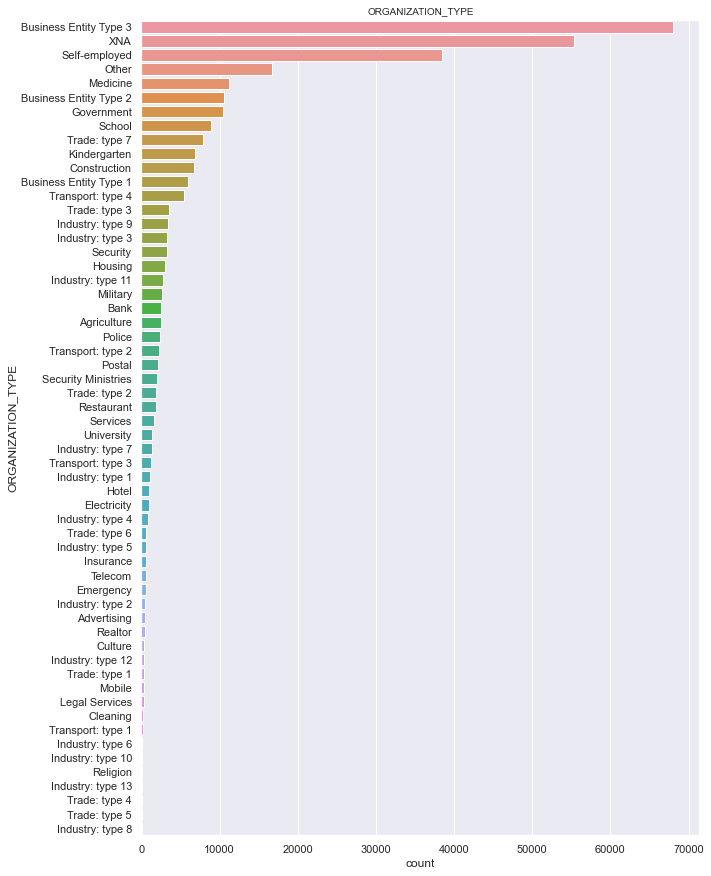

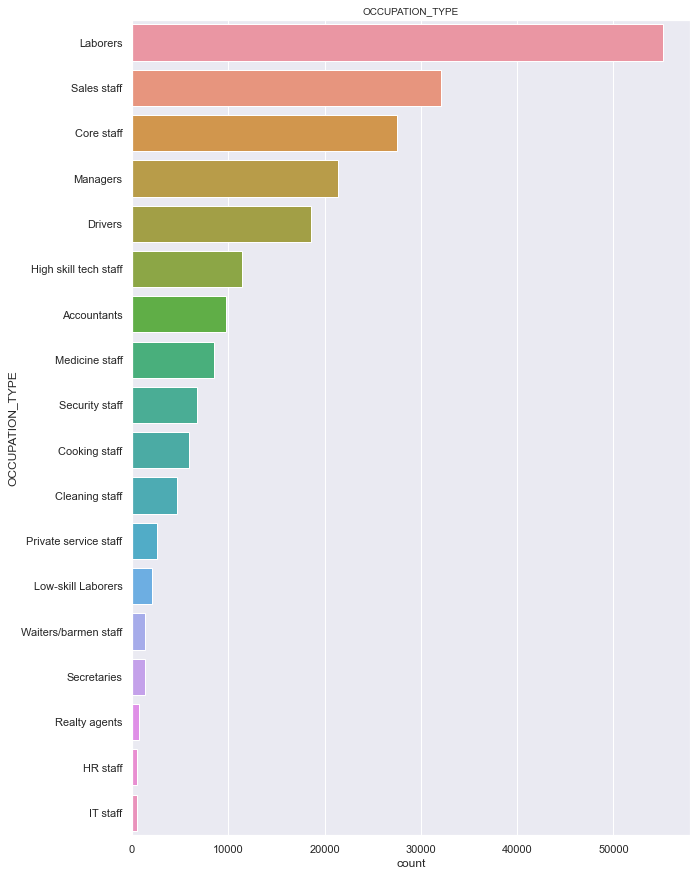

In [25]:
# Analyse visuelle des champs alphanumeriques avec moins de 10 modalites
# un regroupement des variables serait pertinent lors de la phase de feature engeneering
for col in application_train[['ORGANIZATION_TYPE','OCCUPATION_TYPE']]:
    plt.figure(figsize=(10, 15))
    plt.title(col ,fontsize=10)
    #plt.xlabel(col, fontsize=20)
    sns.set(style='darkgrid')
    sns.countplot(y= col, 
                  data=application_train,
                  order = application_train[col].value_counts(normalize=True).index)
    plt.show()

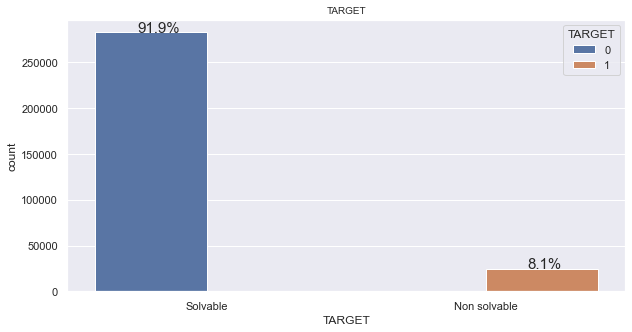

In [26]:
# Analyse visuelle de ma target
# on remarque bien un déséquilibre entre les modalités
plt.figure(figsize=(10, 5))
plt.title('TARGET', fontsize=10)
#plt.xlabel(col, fontsize=20)
ax = sns.countplot(x='TARGET',
                   data=application_train, hue=application_train['TARGET'],
                   order=application_train['TARGET'].value_counts().index)
ax.set_xticklabels(['Solvable','Non solvable'])
without_hue(ax, application_train['TARGET'])

In [25]:
# Regroupement de certaines variables
#https://conceptdaily.com/primary-sector-concept-other-sectors-and-examples/#:~:text=Some%20characteristics%20of%20the%20primary%20sector%3A%201%20It,the%20second
#Regroupement des champs ORGANIZATION_TYPE NAME_TYPE_SUITE OCCUPATION_TYPE
map_ORGANIZATION_TYPE = {'Business Entity Type 3' : 'Business',
                        'Business Entity Type 2': 'Business', 
                        'Business Entity Type 1' : 'Business',
                        'Self-employed' : 'Self_employed',
                        'Medicine' : 'Medicine', 
                        'Emergency' : 'Medecine',
                         'Other' : 'Autres',
                         'School' : 'Ecole', 
                         'Kindergarten' : 'Ecole',
                         'University' : 'Ecole',
                         'Trade: type 7' : 'Commerce',
                         'Trade: type 3' : 'Commerce',
                         'Trade: type 2' : 'Commerce',
                         'Trade: type 6' : 'Commerce',
                         'Trade: type 1' : 'Commerce',
                         'Trade: type 4' : 'Commerce',
                         'Trade: type 5' : 'Commerce',
                         'Transport: type 4' : 'Transport', 
                         'Transport: type 2' : 'Transport',
                         'Transport: type 3': 'Transport',
                         'Transport: type 1' : 'Transport',
                         'Industry type 9':'Industry', 
                         'Industry: type 3':'Industry',
                         'Industry: type 11':'Industry', 
                         'Industry: type 7':'Industry', 
                         'Industry: type 1':'Industry',
                         'Industry: type 4':'Industry', 
                         'Industry: type 5':'Industry',
                         'Industry: type 2':'Industry',
                         'Industry: type 12':'Industry',
                         'Industry: type 6':'Industry', 
                         'Industry: type 10':'Industry', 
                         'Industry: type 8':'Industry',
                         'Industry: type 13':'Industry',
                         'Security':'Securite', 
                         'Military ':'Securite', 
                         'Police':'Securite', 
                         'Security Ministries':'Securite',
                         'Bank':'Service', 
                         'Postal':'Service', 
                         'Services':'Service', 
                         'Hotel':'Service',
                         'Electricity':'Service', 
                         'Insurance':'Service', 
                         'Telecom':'Service',
                         'Advertising':'Service', 
                         'Realtor':'Service', 
                         'Culture':'Service', 
                         'Mobile':'Service', 
                         'Legal Services':'Service',
                         'Cleaning':'Service', 
                         'Agriculture':'Service', 
                         'Restaurant':'Service', 
                         'Construction':'Service', 
                         'Government':'Service',
                         'Housing':'Service',
                         'Religion' :'Religion',
                         'XNA' :'XNA'}


map_NAME_TYPE_SUITE = {'Family':'Accompagné',
                       'Spouse, partner':'Accompagné',
                       'Children':'Accompagné',
                       'Other_A':'Accompagné',
                       'Other_B':'Accompagné',
                       'Group of people':'Accompagné',
                        'Unaccompanied':'Pas_Accompagné'}



map_OCCUPATION_TYPE = {'Laborers' :'Primary_sector',
                       'Low-skill Laborers':'Primary_sector',
                        'Core staff':'Third_sector', 
                       'Accountants':'Third_sector', 
                       'Managers':'Third_sector',
                       'Drivers':'Third_sector',
                      'Sales staff':'Third_sector', 'Cleaning staff':'Third_sector', 'Cooking staff':'Third_sector',
                       'Private service staff':'Third_sector','Medicine staff':'Third_sector', 
                       'Security staff':'Third_sector', 'High skill tech staff':'Third_sector',
                        'Waiters/barmen staff':'Third_sector', 'Low-skill Laborers':'Third_sector', 
                       'Realty agents':'Third_sector', 'Secretaries':'Third_sector',
                        'IT staff':'Third_sector','HR staff':'Third_sector'}


map_NAME_EDUCATION_TYPE  = {'Secondary / secondary special':'Secondary',
                       'Higher education':'Higher education',
                       'Incomplete higher':'Incomplete higher',
                       'Lower secondary':'Secondary',
                       'Academic degree':'Higher education'}


application_train['ORGANIZATION_TYPE'] = application_train['ORGANIZATION_TYPE'].map(map_ORGANIZATION_TYPE)
application_train['NAME_TYPE_SUITE'] = application_train['NAME_TYPE_SUITE'].map(map_NAME_TYPE_SUITE)
application_train['OCCUPATION_TYPE_'] = application_train['OCCUPATION_TYPE'].map(map_OCCUPATION_TYPE)
application_train['NAME_EDUCATION_TYPE'] = application_train['NAME_EDUCATION_TYPE'].map(map_NAME_EDUCATION_TYPE)


#### Champs numeriques

In [28]:
application_train.select_dtypes(exclude=['object']).columns

Index(['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=106)

In [29]:
# je vais selectionner les champs pertinents
df = application_train[['CNT_CHILDREN', 'AMT_INCOME_TOTAL',
                  'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE','DAYS_BIRTH', 'DAYS_EMPLOYED',
                  'EXT_SOURCE_1','EXT_SOURCE_2', 'EXT_SOURCE_3']]

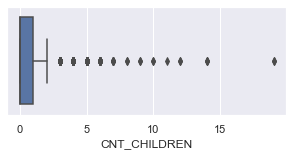

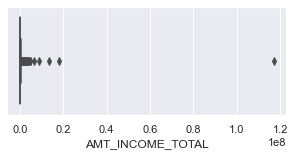

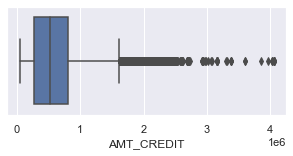

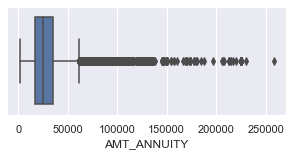

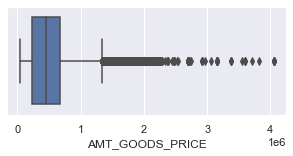

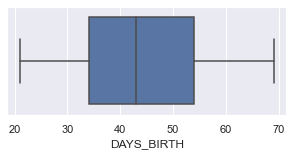

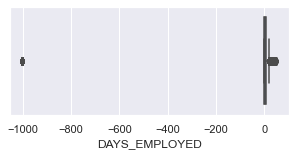

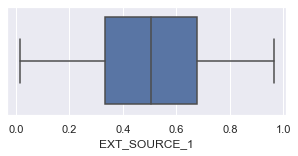

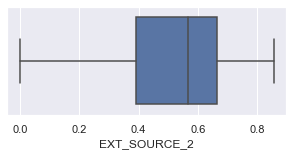

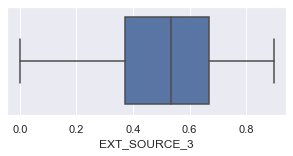

In [30]:
# Analyse des boxplots de mes données
# Avec la multitude des champs, il faudra selectionner uniquement les champs pertinents
for col in df.select_dtypes(exclude=['object']):
    plt.figure(figsize=(5, 2))
    sns.boxplot(x=df[col])
    plt.show()

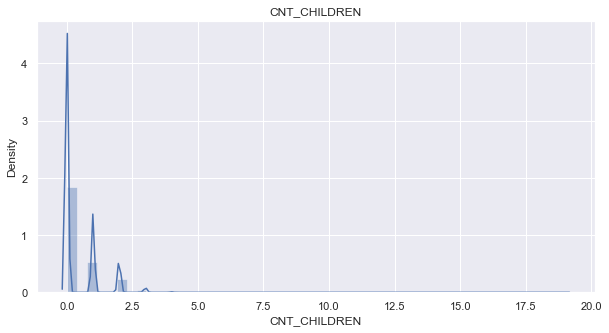

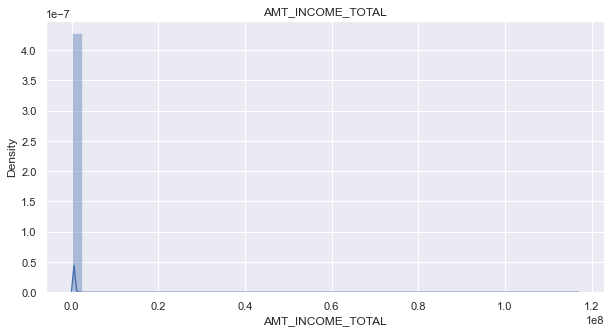

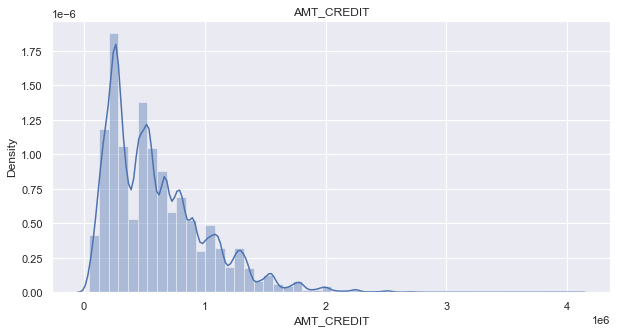

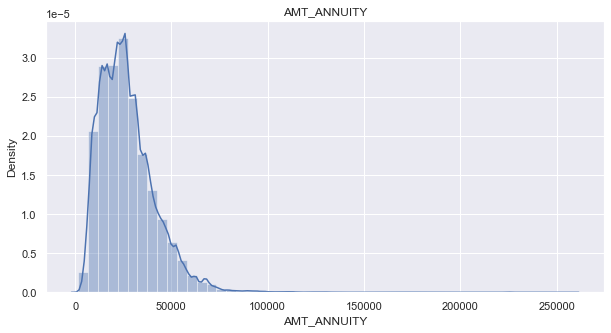

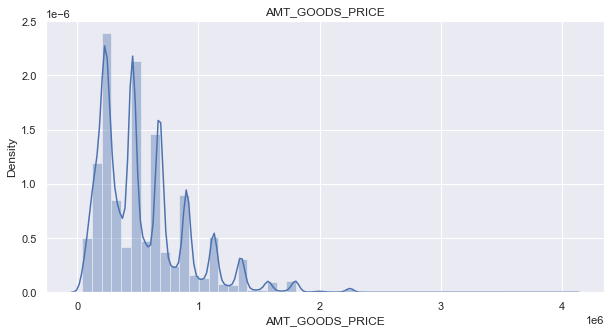

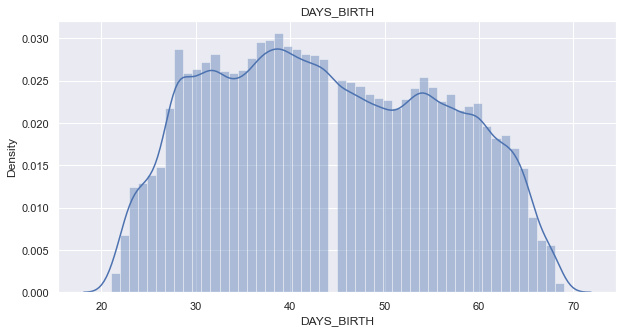

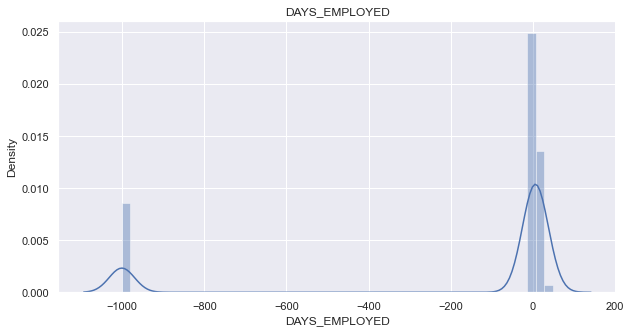

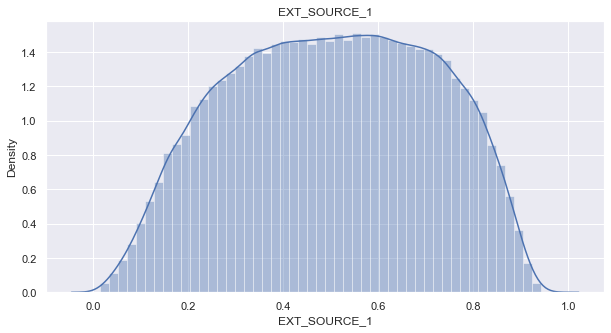

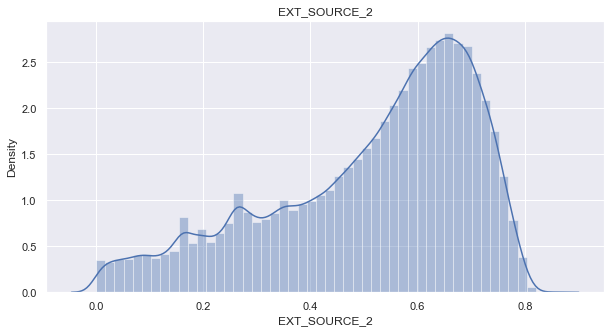

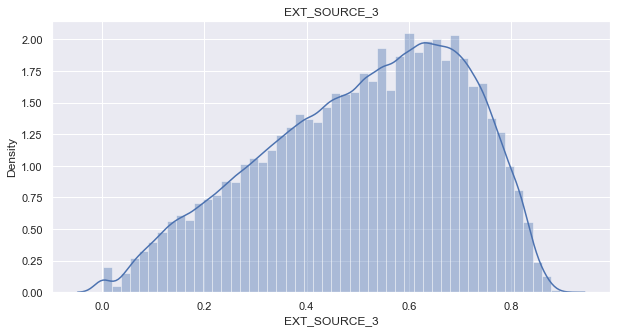

In [31]:
# Analyse des densités
for col in df.select_dtypes(exclude=['object']):
    plt.figure(figsize=(10, 5))
    sns.distplot(df[col], kde=True,
                 axlabel=col).set(title=col)

array([[<AxesSubplot:title={'center':'CNT_CHILDREN'}>,
        <AxesSubplot:title={'center':'AMT_INCOME_TOTAL'}>,
        <AxesSubplot:title={'center':'AMT_CREDIT'}>],
       [<AxesSubplot:title={'center':'AMT_ANNUITY'}>,
        <AxesSubplot:title={'center':'AMT_GOODS_PRICE'}>,
        <AxesSubplot:title={'center':'DAYS_BIRTH'}>],
       [<AxesSubplot:title={'center':'DAYS_EMPLOYED'}>,
        <AxesSubplot:title={'center':'EXT_SOURCE_1'}>,
        <AxesSubplot:title={'center':'EXT_SOURCE_2'}>],
       [<AxesSubplot:title={'center':'EXT_SOURCE_3'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

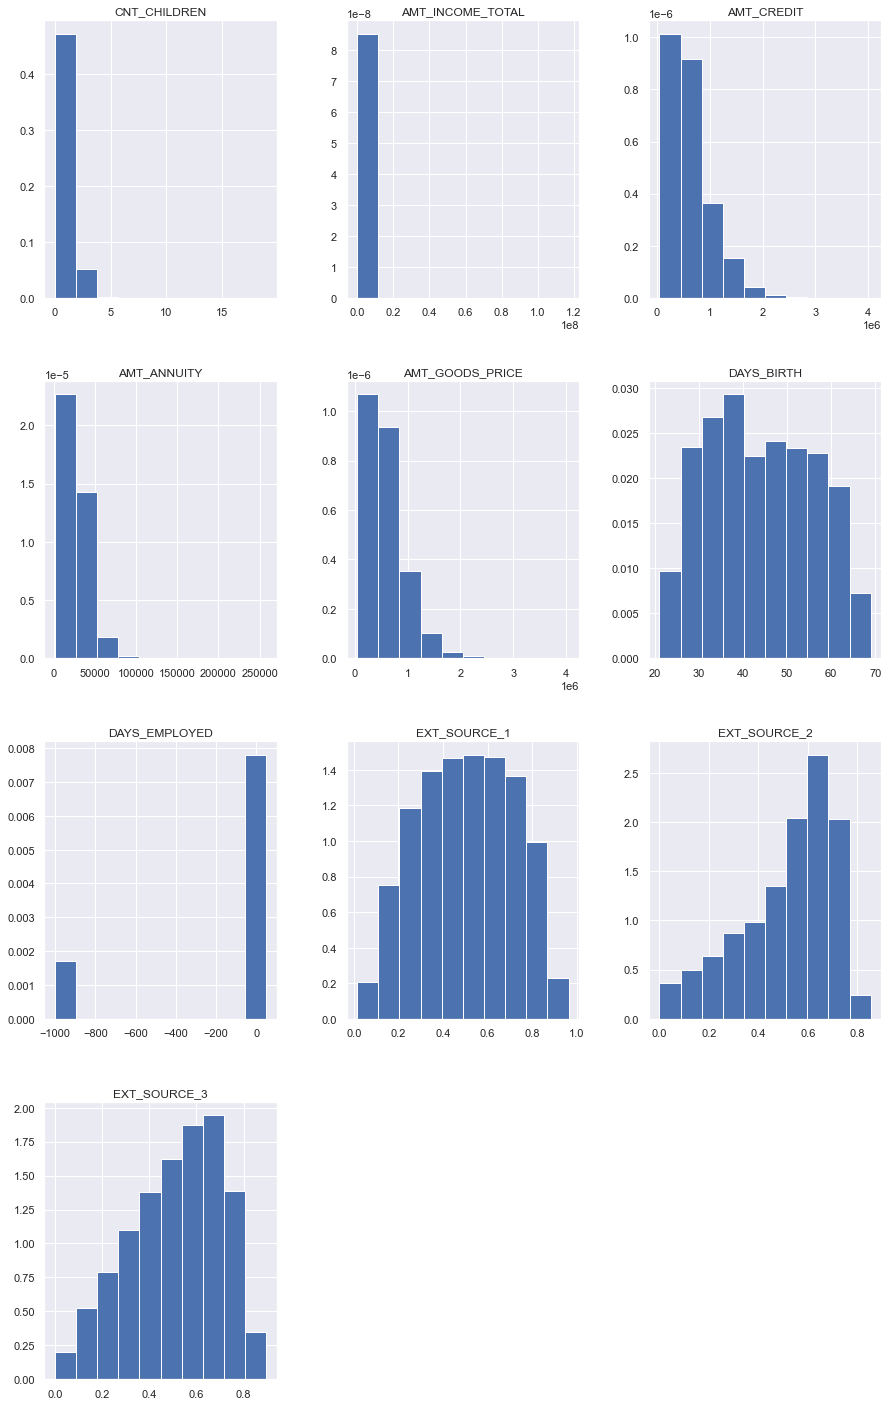

In [32]:
# autre types de visualisations
features = ['CNT_CHILDREN', 'AMT_INCOME_TOTAL',
                  'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE','DAYS_BIRTH', 'DAYS_EMPLOYED',
                  'EXT_SOURCE_1','EXT_SOURCE_2', 'EXT_SOURCE_3']
application_train[features].hist(figsize=(15, 25),density = True)

In [33]:
# Statistiques descriptives de l'ensemble des champs numeriques
# on constate un signe négatif pour le champ days_employed, je vais passer ces jours negatifs  à vide
pd.set_option('display.max_columns',application_train.select_dtypes(exclude=['object']).shape[1])
application_train.select_dtypes(exclude=['object']).describe()

SK_ID_CURR         TARGET   CNT_CHILDREN  AMT_INCOME_TOTAL  \
count  307511.000000  307511.000000  307511.000000      3.075110e+05   
mean   278180.518577       0.080729       0.417052      1.687979e+05   
std    102790.175348       0.272419       0.722121      2.371231e+05   
min    100002.000000       0.000000       0.000000      2.565000e+04   
25%    189145.500000       0.000000       0.000000      1.125000e+05   
50%    278202.000000       0.000000       0.000000      1.471500e+05   
75%    367142.500000       0.000000       1.000000      2.025000e+05   
max    456255.000000       1.000000      19.000000      1.170000e+08   

         AMT_CREDIT    AMT_ANNUITY  AMT_GOODS_PRICE  \
count  3.075110e+05  307499.000000     3.072330e+05   
mean   5.990260e+05   27108.573909     5.383962e+05   
std    4.024908e+05   14493.737315     3.694465e+05   
min    4.500000e+04    1615.500000     4.050000e+04   
25%    2.700000e+05   16524.000000     2.385000e+05   
50%    5.135310e+05   24903.000000     4.500000e+05   
75%    8.086500e+05   34596.000000     6.795000e+05   
max    4.050000e+06  258025.500000     4.050000e+06   

       REGION_POPULATION_RELATIVE     DAYS_BIRTH  DAYS_EMPLOYED  \
count               307511.000000  307511.000000  307511.000000   
mean                     0.020868      43.938646    -174.895337   
std                      0.013831      11.964047     387.185661   
min                      0.000290      21.000000   -1001.000000   
25%                      0.010006      34.000000       1.000000   
50%                      0.018850      43.000000       3.000000   
75%                      0.028663      54.000000       8.000000   
max                      0.072508      69.000000      49.000000   

       DAYS_REGISTRATION  DAYS_ID_PUBLISH    OWN_CAR_AGE     FLAG_MOBIL  \
count      307511.000000    307511.000000  104582.000000  307511.000000   
mean           13.659440         8.198575      12.061091       0.999997   
std             9.659369         4.151520      11.944812       0.001803   
min             0.000000         0.000000       0.000000       0.000000   
25%             6.000000         5.000000       5.000000       1.000000   
50%            12.000000         9.000000       9.000000       1.000000   
75%            20.000000        12.000000      15.000000       1.000000   
max            68.000000        20.000000      91.000000       1.000000   

       FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE     FLAG_PHONE  \
count   307511.000000    307511.000000     307511.000000  307511.000000   
mean         0.819889         0.199368          0.998133       0.281066   
std          0.384280         0.399526          0.043164       0.449521   
min          0.000000         0.000000          0.000000       0.000000   
25%          1.000000         0.000000          1.000000       0.000000   
50%          1.000000         0.000000          1.000000       0.000000   
75%          1.000000         0.000000          1.000000       1.000000   
max          1.000000         1.000000          1.000000       1.000000   

          FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
count  307511.000000    307509.000000         307511.000000   
mean        0.056720         2.152665              2.052463   
std         0.231307         0.910682              0.509034   
min         0.000000         1.000000              1.000000   
25%         0.000000         2.000000              2.000000   
50%         0.000000         2.000000              2.000000   
75%         0.000000         3.000000              2.000000   
max         1.000000        20.000000              3.000000   

       REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
count                307511.000000            307511.000000   
mean                      2.031521                12.063419   
std                       0.502737                 3.265832   
min                       1.000000                 0.000000   
25%                       

In [34]:
# Analyse des clients avec un defaut de credit
DF_TARGET0 = application_train.select_dtypes(exclude=['object'])
DF_TARGET0 = DF_TARGET0.loc[DF_TARGET0['TARGET']==0]
pd.set_option('display.max_columns',DF_TARGET0.shape[1])
DF_TARGET0.describe()

SK_ID_CURR    TARGET   CNT_CHILDREN  AMT_INCOME_TOTAL    AMT_CREDIT  \
count  282686.000000  282686.0  282686.000000      2.826860e+05  2.826860e+05   
mean   278244.744536       0.0       0.412946      1.690777e+05  6.026483e+05   
std    102825.776954       0.0       0.718843      1.104763e+05  4.068459e+05   
min    100003.000000       0.0       0.000000      2.565000e+04  4.500000e+04   
25%    189103.250000       0.0       0.000000      1.125000e+05  2.700000e+05   
50%    278362.500000       0.0       0.000000      1.485000e+05  5.177880e+05   
75%    367241.500000       0.0       1.000000      2.025000e+05  8.100000e+05   
max    456255.000000       0.0      19.000000      1.800009e+07  4.050000e+06   

         AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  \
count  282674.000000     2.824290e+05               282686.000000   
mean    27163.623349     5.427368e+05                    0.021021   
std     14658.307178     3.737855e+05                    0.013978   
min      1615.500000     4.050000e+04                    0.000290   
25%     16456.500000     2.385000e+05                    0.010006   
50%     24876.000000     4.500000e+05                    0.018850   
75%     34749.000000     6.885000e+05                    0.028663   
max    258025.500000     4.050000e+06                    0.072508   

          DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  \
count  282686.000000  282686.000000      282686.000000    282686.000000   
mean       44.216123    -180.050660          13.779147         8.261753   
std        11.964511     391.576321           9.702002         4.144000   
min        21.000000   -1001.000000           0.000000         0.000000   
25%        34.000000       1.000000           6.000000         5.000000   
50%        43.000000       3.000000          12.000000         9.000000   
75%        54.000000       8.000000          21.000000        12.000000   
max        69.000000      49.000000          68.000000        20.000000   

        OWN_CAR_AGE     FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
count  97006.000000  282686.000000   282686.000000    282686.000000   
mean      11.935540       0.999996        0.814653         0.195991   
std       11.891359       0.001881        0.388579         0.396963   
min        0.000000       0.000000        0.000000         0.000000   
25%        5.000000       1.000000        1.000000         0.000000   
50%        9.000000       1.000000        1.000000         0.000000   
75%       15.000000       1.000000        1.000000         0.000000   
max       91.000000       1.000000        1.000000         1.000000   

       FLAG_CONT_MOBILE     FLAG_PHONE     FLAG_EMAIL  CNT_FAM_MEMBERS  \
count     282686.000000  282686.000000  282686.000000    282684.000000   
mean           0.998129       0.284238       0.056840         2.150154   
std            0.043219       0.451051       0.231538         0.906984   
min            0.000000       0.000000       0.000000         1.000000   
25%            1.000000       0.000000       0.000000         2.000000   
50%            1.000000       0.000000       0.000000         2.000000   
75%            1.000000       1.000000       0.000000         3.000000   
max            1.000000       1.000000       1.000000        20.000000   

       REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
count         282686.000000                282686.000000   
mean               2.043578                     2.022449   
std                0.508422                     0.501971   
min                1.000000                     1.000000   
25%                2.000000                     2.000000   
50%                2.000000                     2.000000   
75%                2.000000                     2.000000   
max                3.000000                     3.000000   

       HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
count            282686.000000               282686.000000   
mean      

In [36]:
# Analyse des clients sans un defaut de credit
DF_TARGET1 = application_train.select_dtypes(exclude=['object'])
DF_TARGET1 = DF_TARGET1.loc[DF_TARGET1['TARGET']==1]
pd.set_option('display.max_columns',DF_TARGET1.shape[1])
DF_TARGET1.describe()

SK_ID_CURR   TARGET  CNT_CHILDREN  AMT_INCOME_TOTAL    AMT_CREDIT  \
count   24825.000000  24825.0  24825.000000      2.482500e+04  2.482500e+04   
mean   277449.167936      1.0      0.463807      1.656118e+05  5.577785e+05   
std    102383.123458      0.0      0.756903      7.466770e+05  3.464332e+05   
min    100002.000000      1.0      0.000000      2.565000e+04  4.500000e+04   
25%    189555.000000      1.0      0.000000      1.125000e+05  2.844000e+05   
50%    276291.000000      1.0      0.000000      1.350000e+05  4.975200e+05   
75%    366050.000000      1.0      1.000000      2.025000e+05  7.333155e+05   
max    456254.000000      1.0     11.000000      1.170000e+08  4.027680e+06   

         AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  \
count   24825.000000     2.480400e+04                24825.000000   
mean    26481.744290     4.889724e+05                    0.019131   
std     12450.676999     3.116365e+05                    0.011905   
min      2722.500000     4.500000e+04                    0.000533   
25%     17361.000000     2.385000e+05                    0.009630   
50%     25263.000000     4.500000e+05                    0.018634   
75%     32976.000000     6.750000e+05                    0.025164   
max    149211.000000     3.600000e+06                    0.072508   

         DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  \
count  24825.000000   24825.000000       24825.000000     24825.000000   
mean      40.778973    -116.190896          12.296314         7.479154   
std       11.495961     327.463734           9.049089         4.169302   
min       21.000000   -1001.000000           0.000000         0.000000   
25%       31.000000       1.000000           5.000000         4.000000   
50%       39.000000       3.000000          11.000000         8.000000   
75%       49.000000       6.000000          18.000000        11.000000   
max       69.000000      44.000000          63.000000        17.000000   

       OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
count  7576.000000     24825.0    24825.000000     24825.000000   
mean     13.668691         1.0        0.879517         0.237825   
std      12.499074         0.0        0.325532         0.425760   
min       0.000000         1.0        0.000000         0.000000   
25%       6.000000         1.0        1.000000         0.000000   
50%      11.000000         1.0        1.000000         0.000000   
75%      17.000000         1.0        1.000000         0.000000   
max      91.000000         1.0        1.000000         1.000000   

       FLAG_CONT_MOBILE    FLAG_PHONE    FLAG_EMAIL  CNT_FAM_MEMBERS  \
count      24825.000000  24825.000000  24825.000000     24825.000000   
mean           0.998187      0.244955      0.055347         2.181269   
std            0.042538      0.430069      0.228662         0.951327   
min            0.000000      0.000000      0.000000         1.000000   
25%            1.000000      0.000000      0.000000         2.000000   
50%            1.000000      0.000000      0.000000         2.000000   
75%            1.000000      0.000000      0.000000         3.000000   
max            1.000000      1.000000      1.000000        13.000000   

       REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
count          24825.000000                 24825.000000   
mean               2.153635                     2.134824   
std                0.505052                     0.499909   
min                1.000000                     1.000000   
25%                2.000000                     2.000000   
50%                2.000000                     2.000000   
75%                2.000000                     2.000000   
max                3.000000                     3.000000   

       HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
count             24825.000000                24825.000000   
mean                 11.797100                    0.017442   
std                   3.28429

In [26]:
#passage à vide des valeurs inférieures à 0 dans le champ DAYS_EMPLOYED
application_train.loc[application_train['DAYS_EMPLOYED'] < 0,'DAYS_EMPLOYED'] = np.nan

#### croisement de ma target et des champs alphanumeriques

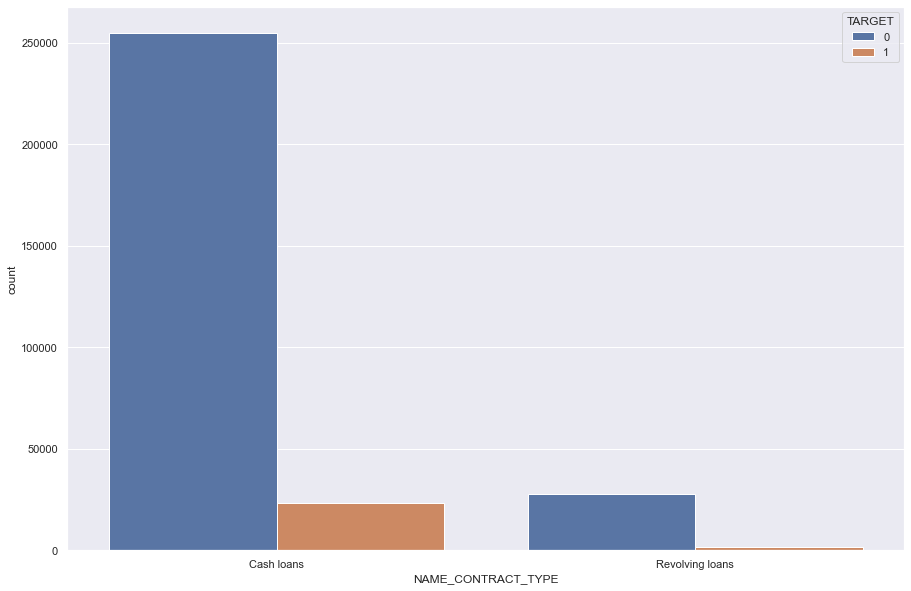

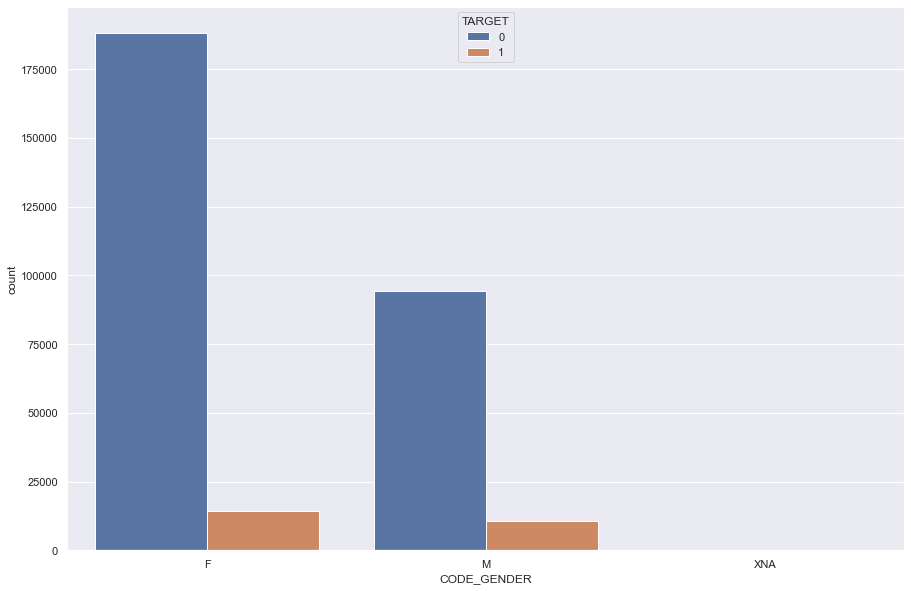

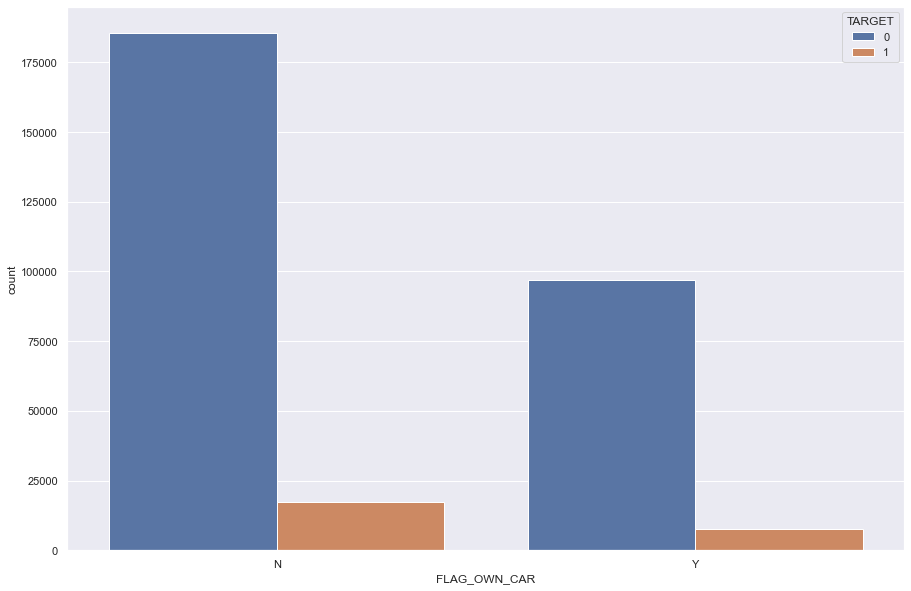

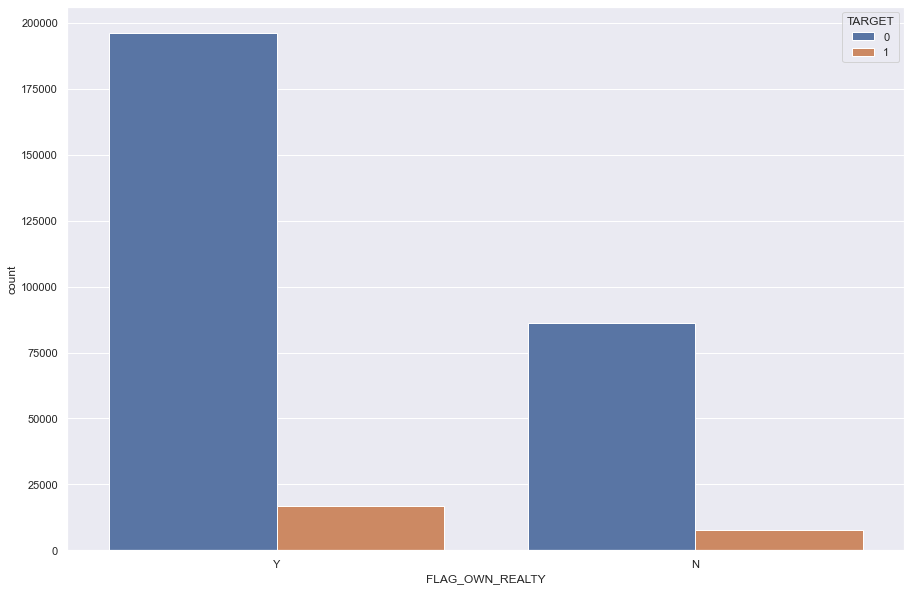

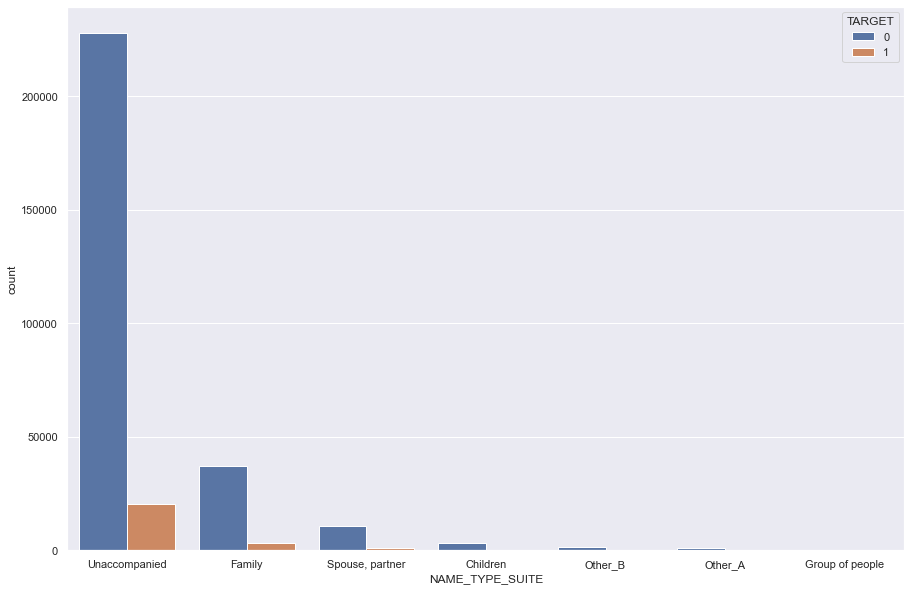

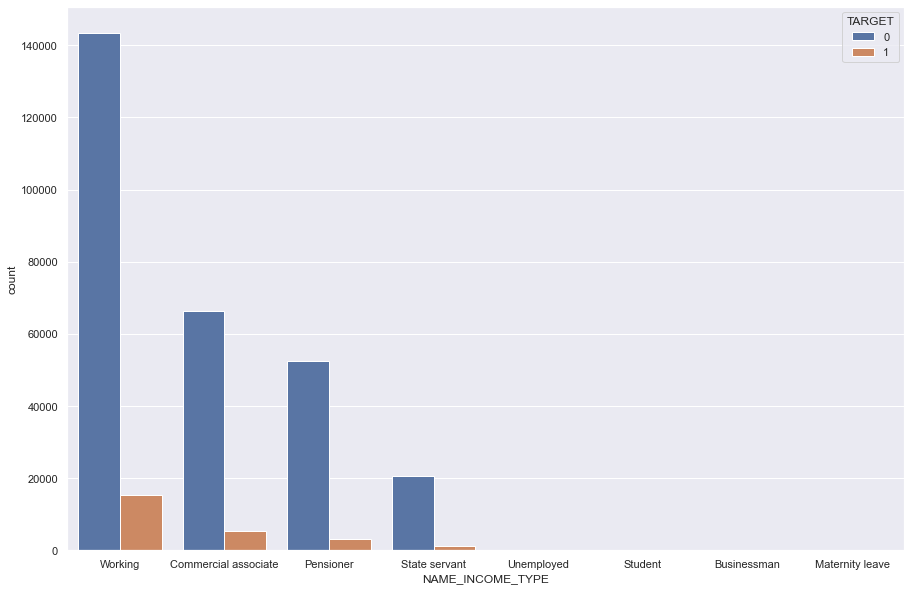

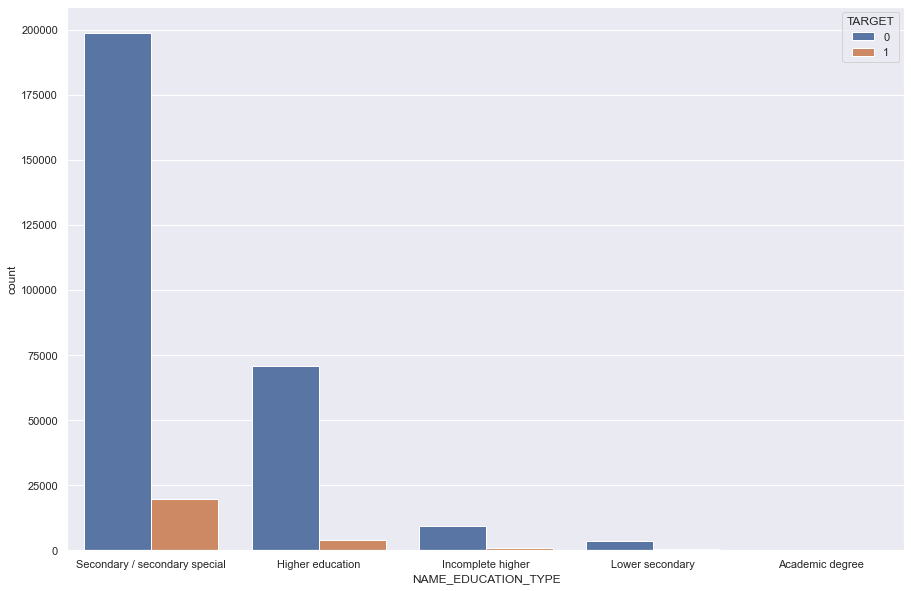

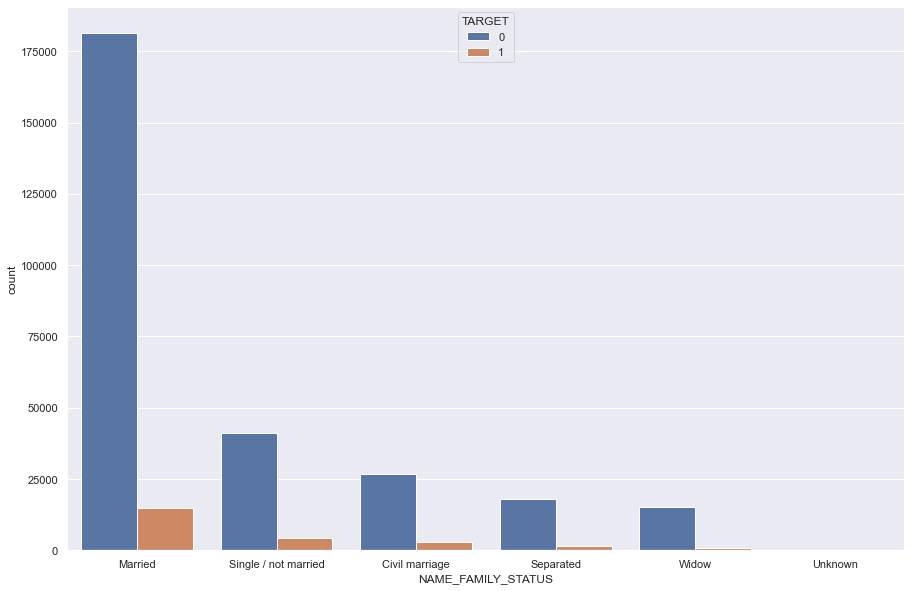

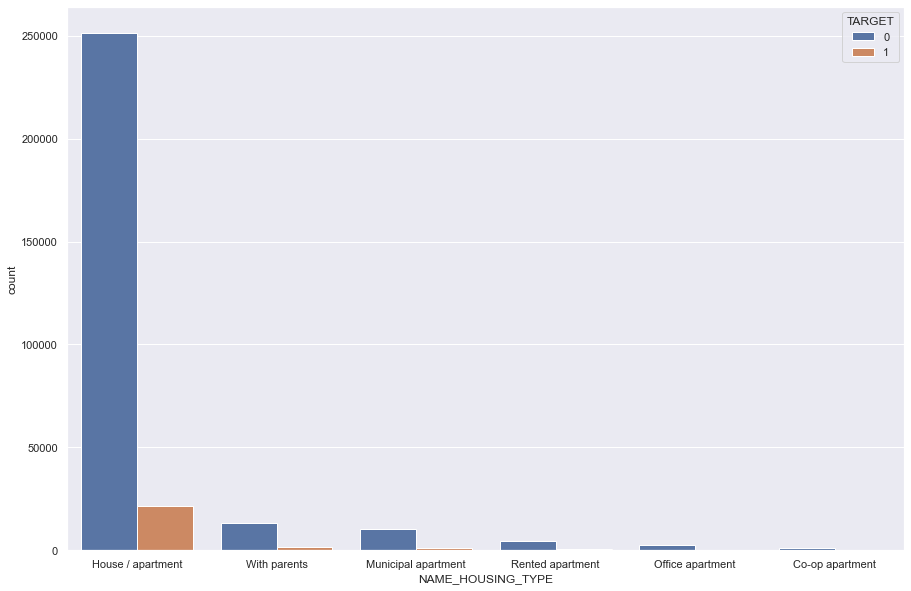

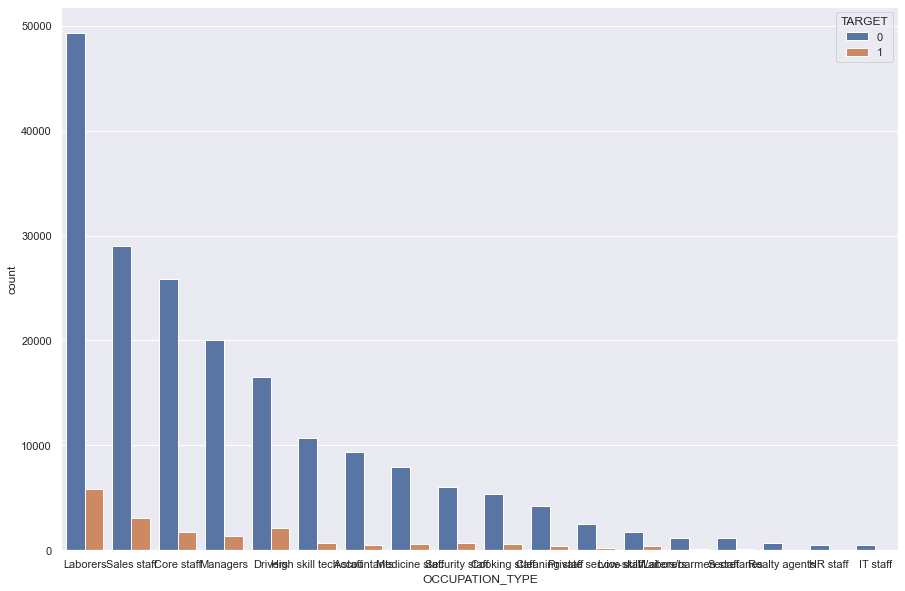

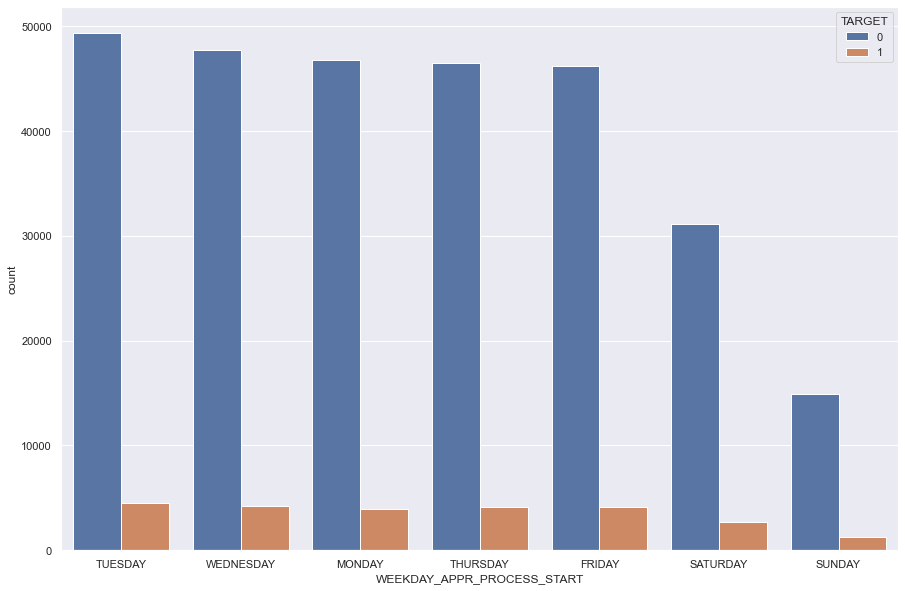

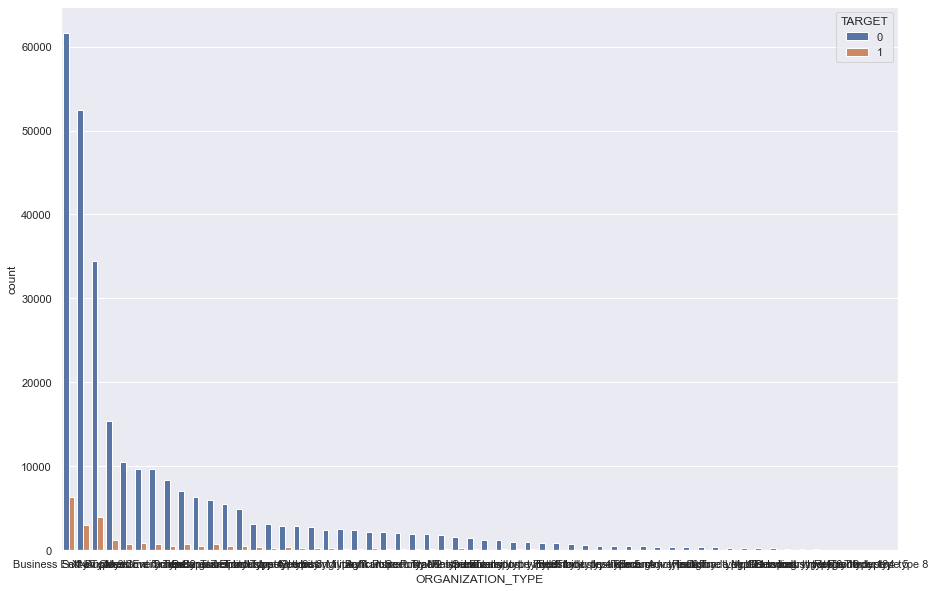

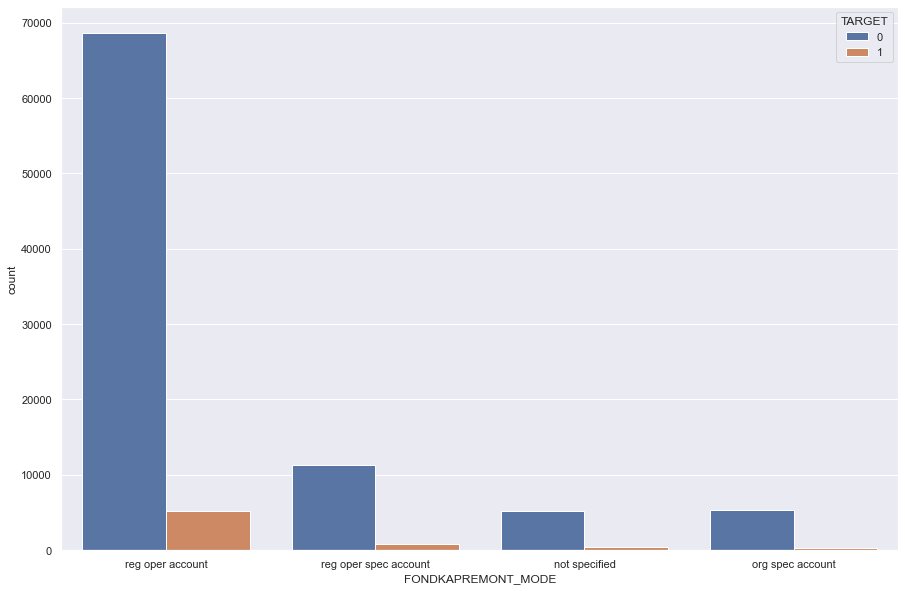

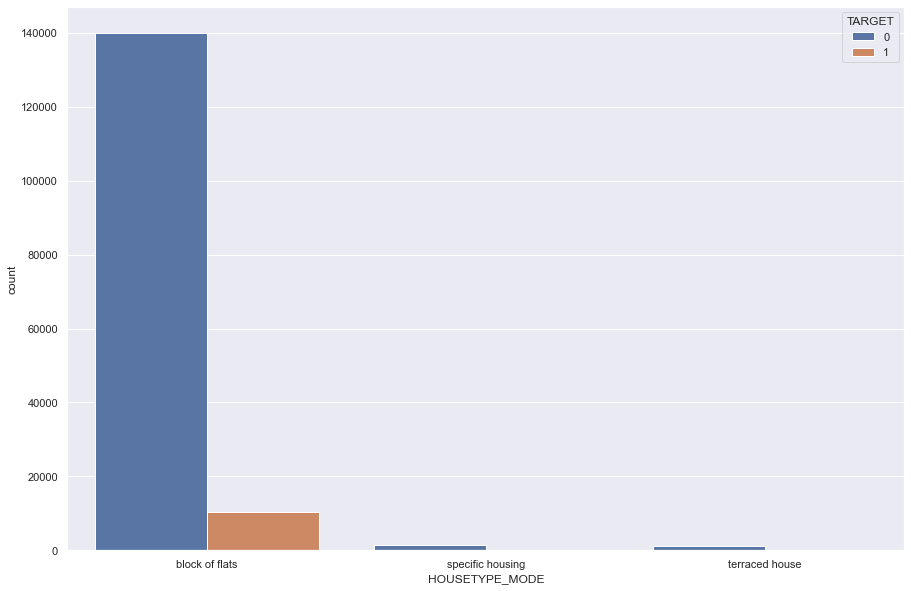

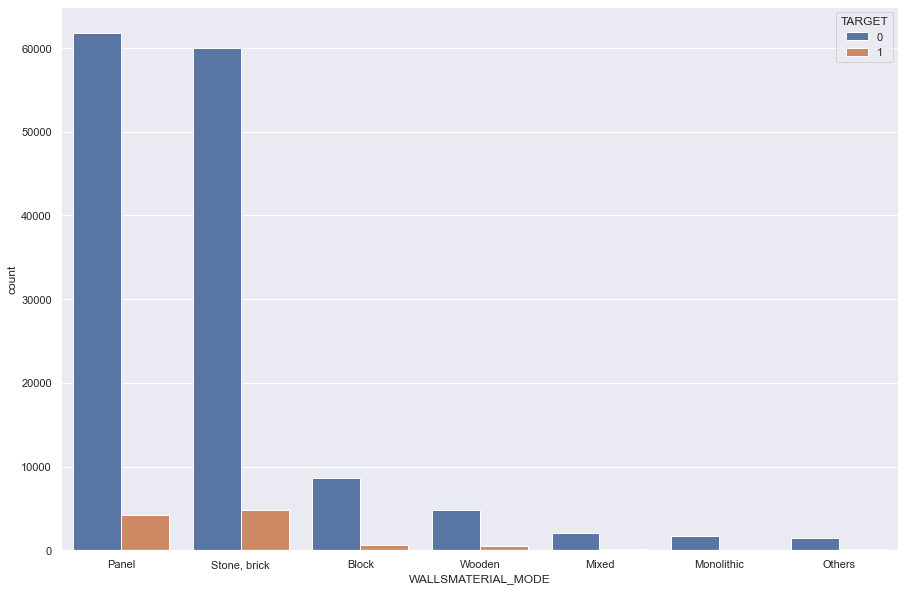

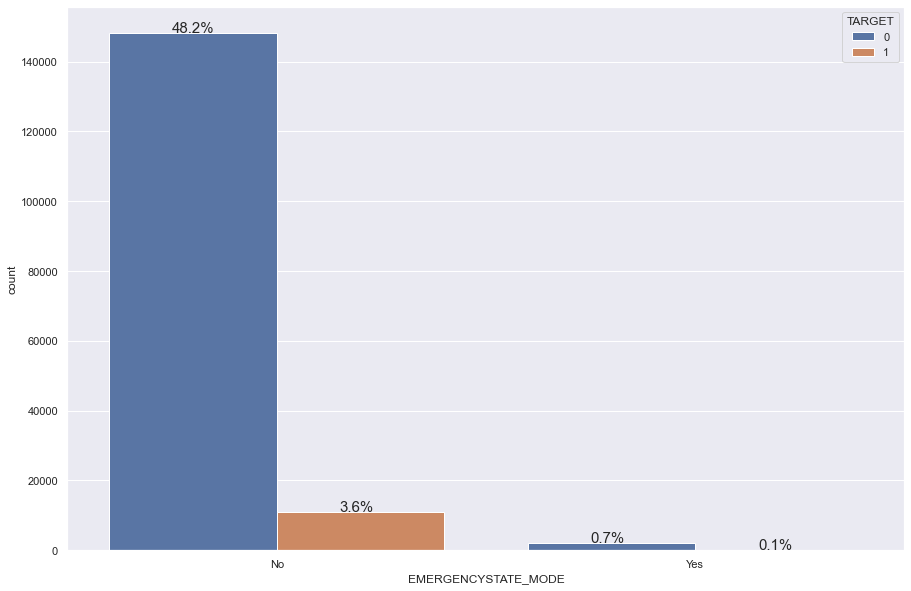

In [88]:
for col in application_train.select_dtypes('object'):
    fig = plt.figure(figsize=(15,10))
    sns.set(style='darkgrid')
    #plt.title(col,fontsize=20)
    ax = sns.countplot(x =col, 
                  data=application_train,hue='TARGET',
                  order = application_train[col].value_counts().index)

#### croisement de ma target et des champs numeriques

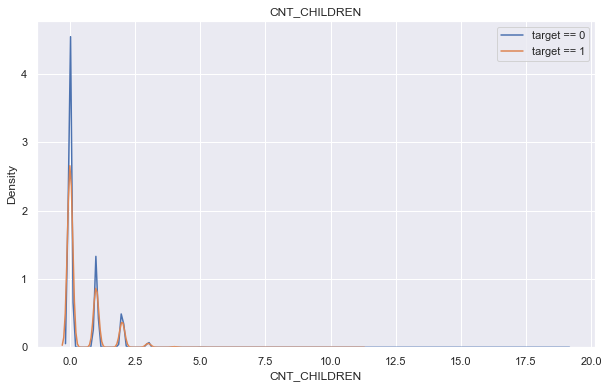

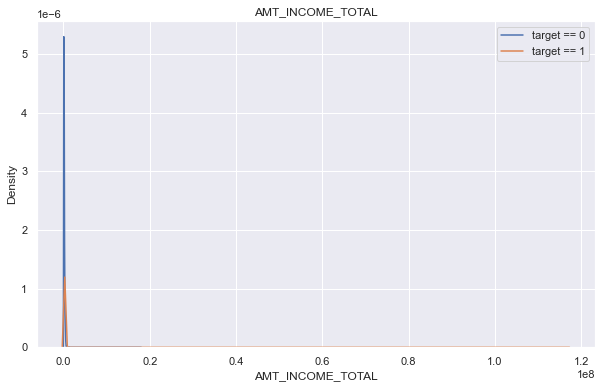

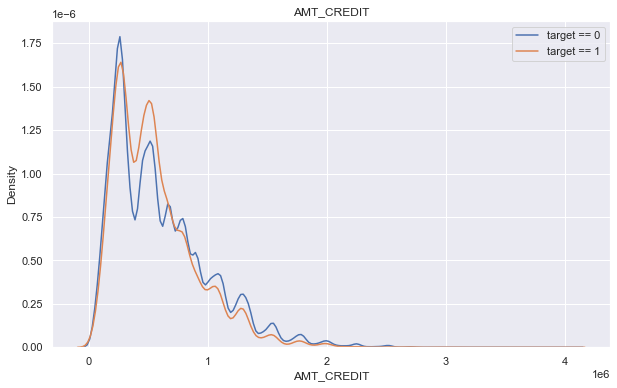

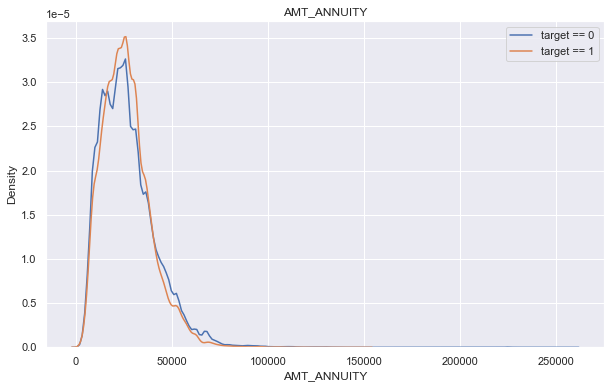

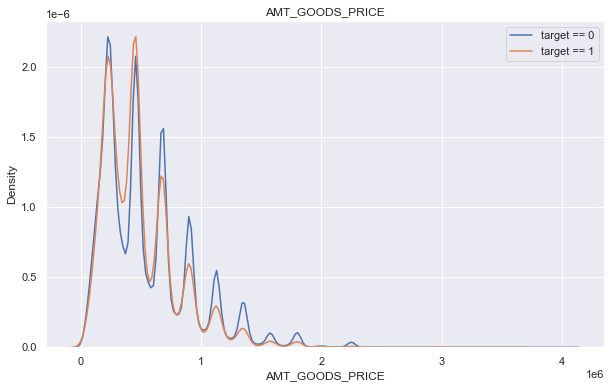

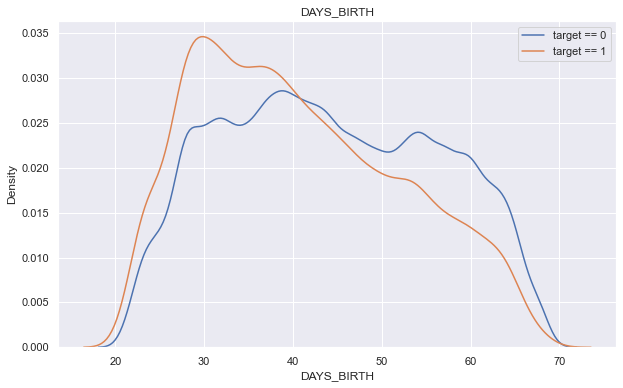

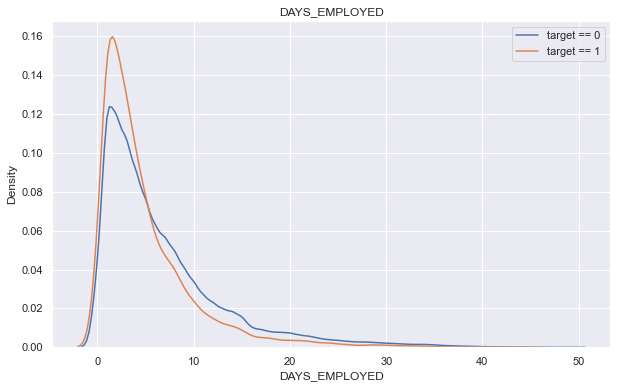

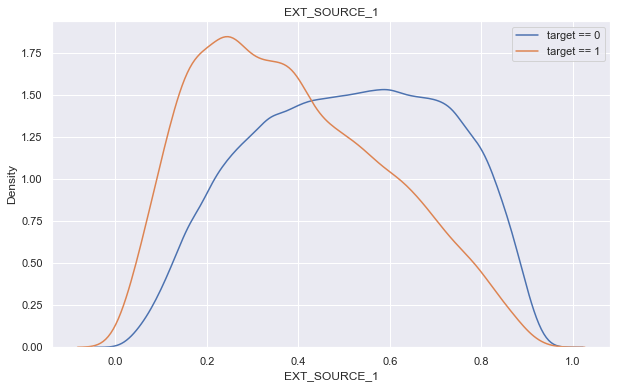

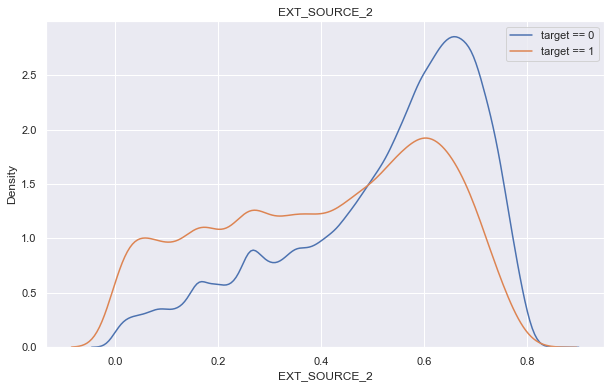

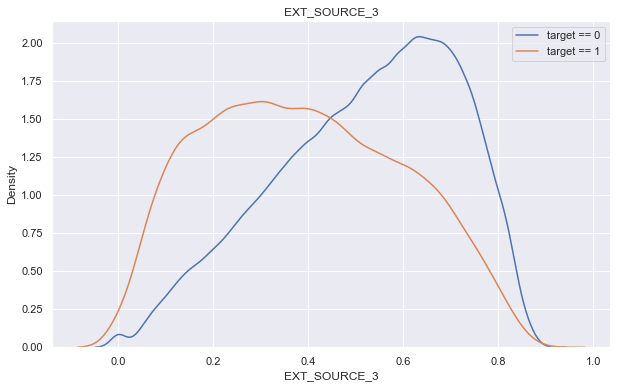

In [40]:
# Analyse des champs pertinents 
croisement = ['CNT_CHILDREN', 'AMT_INCOME_TOTAL',
                  'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE','DAYS_BIRTH', 'DAYS_EMPLOYED',
                  'EXT_SOURCE_1','EXT_SOURCE_2', 'EXT_SOURCE_3']
for col in croisement:
    plt.figure(figsize=(10, 6))
    # KDE densite par noyau plot des prets qui ont ete remboursés
    sns.kdeplot(application_train.loc[application_train['TARGET'] == 0, col], label= 'target == 0')
    # KDE plot des prets qui n'ont pas ete remboursés
    sns.kdeplot(application_train.loc[application_train['TARGET'] == 1, col], label= 'target == 1')
    # Labeling of plot
    plt.xlabel(col);
    plt.ylabel('Density');
    plt.legend();
    plt.title(col);

<AxesSubplot:>

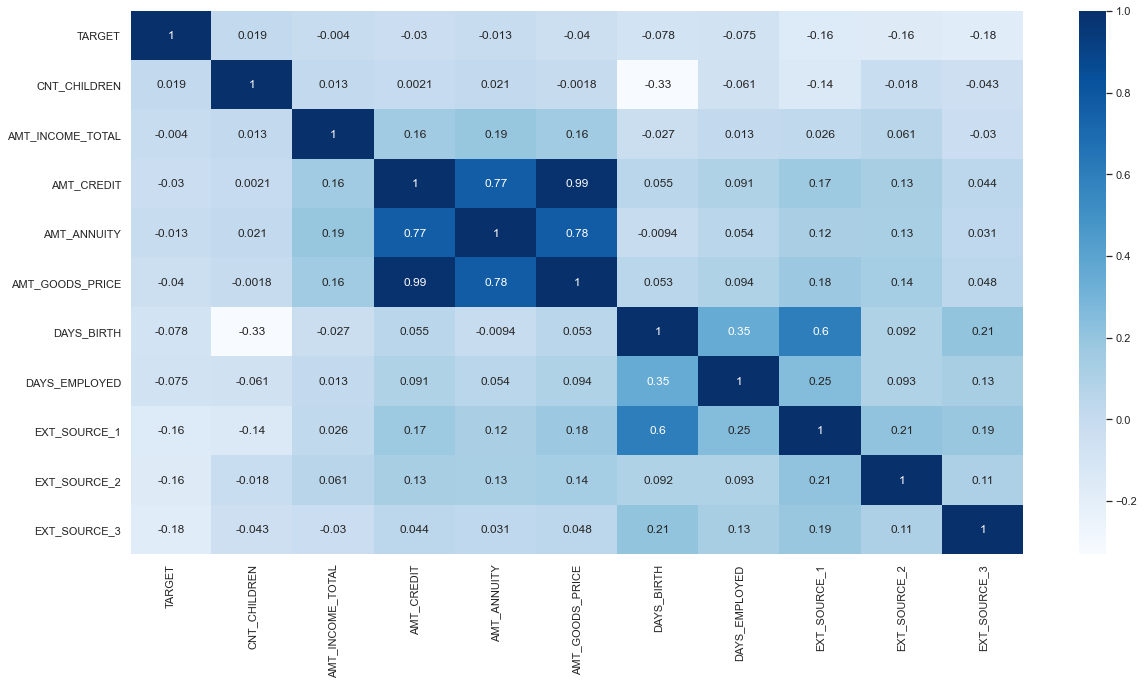

In [41]:
# Matrice de correlation les champs numeriques et ma target 
# Il y'a trop de variables pour utiliser une heatmap
# On pourrait se focaliser sur quelques champs
plt.figure(figsize=(20, 10))
sns.heatmap(application_train[['TARGET','CNT_CHILDREN', 'AMT_INCOME_TOTAL',
                  'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE','DAYS_BIRTH', 'DAYS_EMPLOYED',
                  'EXT_SOURCE_1','EXT_SOURCE_2', 'EXT_SOURCE_3']].corr(),cmap="Blues",annot=True)

In [42]:
#Calcul de la correlation entre ma target et l'ensemble de mes données numeriques
correlation =  []
champs = []
for col in application_train.select_dtypes(exclude=['object']):
    valeur_corr = application_train['TARGET'].corr(application_train[col])
    champs.append(col)
    correlation.append(valeur_corr)
    Correlation_Target = pd.DataFrame(list(zip(champs, correlation)),
               columns =['Champs', 'valeur_corr'])

In [43]:
# je regarde les 5 valeurs de R2 les plus elevées afin de determiner un seuil de selection
# les correlations positives avec notre TARGET sont tres faibles
large5 = Correlation_Target.nlargest(5, "valeur_corr")
large5

Champs  valeur_corr
1                        TARGET     1.000000
21  REGION_RATING_CLIENT_W_CITY     0.060893
20         REGION_RATING_CLIENT     0.058899
27       REG_CITY_NOT_WORK_CITY     0.050994
14               FLAG_EMP_PHONE     0.045982

In [44]:
# Analyse des champs ayant une correlation avec notre TARGET positive ou negative superieur à 0,1
# les correlations negatives avec notre target aussi très faibles
Correlation_Target.loc[(Correlation_Target['valeur_corr'] > 0.1) | (Correlation_Target['valeur_corr'] < - 0.1)]

Champs  valeur_corr
1         TARGET     1.000000
29  EXT_SOURCE_1    -0.155317
30  EXT_SOURCE_2    -0.160472
31  EXT_SOURCE_3    -0.178919

# FEATURE ENGENEERING

In [81]:
# Creation de tranche pour la date de naissance et la duree d'emploi car ce sont des champs pertinents
# creation de quantiles pour decoupage de l'age en classe
Classe = ['(20.0, 25.0]', '(25.0, 30.0]', '(30.0, 35.0]', '(35.0, 40.0]', '(40.0, 45.0]','(45.0, 50.0]',
         '(50.0, 55.0]', '(55.0, 60.0]', '(60.0, 65.0]', '(65.0, 70.0]']
application_train['TRANCHE_AGE'] = pd.cut(application_train['DAYS_BIRTH'], 
                                          bins=[20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70],labels=Classe)

In [94]:
application_train['TRANCHE_AGE'].value_counts()

(35.0, 40.0]    43297
(40.0, 45.0]    40585
(30.0, 35.0]    39473
(45.0, 50.0]    34924
(50.0, 55.0]    34910
(25.0, 30.0]    34656
(55.0, 60.0]    33045
(60.0, 65.0]    25965
(20.0, 25.0]    14213
(65.0, 70.0]     6443
Name: TRANCHE_AGE, dtype: int64

In [95]:
application_train['TRANCHE_AGE'] = application_train['TRANCHE_AGE'].astype(str)

## Application du code du kernel Kaggle

In [59]:
# Utilisation du Kernel kaggle pour la préparation des données
# Utilisation d'un premier modele de regression

import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies


def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_columns = [
        col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns,
                        dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv


def application_train_test(num_rows=None, nan_as_category=False):
    # Read data and merge
    df = application_train
    print("Train samples: {}".format(len(df)))
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']

    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)

    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    gc.collect()
    return df

# Preprocess bureau.csv and bureau_balance.csv


def bureau_and_balance(num_rows=None, nan_as_category=True):
    bureau = pd.read_csv('../Downloads/bureau.csv', nrows=num_rows)
    bb = pd.read_csv('../Downloads/bureau_balance.csv', nrows=num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)

    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper()
                              for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace=True)
    del bb, bb_agg
    gc.collect()

    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['mean'],
        'DAYS_CREDIT_ENDDATE': ['mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['mean'],
        'AMT_CREDIT_SUM_DEBT': ['mean'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean'],
        'AMT_ANNUITY': ['mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat:
        cat_aggregations[cat] = ['mean']
    for cat in bb_cat:
        cat_aggregations[cat + "_MEAN"] = ['mean']

    bureau_agg = bureau.groupby('SK_ID_CURR').agg(
        {**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(
        ['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(
        ['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(
        ['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

# Preprocess previous_applications.csv


def previous_applications(num_rows=None, nan_as_category=True):
    prev = pd.read_csv('../Downloads/previous_application.csv', nrows=num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category=True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace=True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace=True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace=True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace=True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace=True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['mean'],
        'AMT_APPLICATION': ['mean'],
        'AMT_CREDIT': ['mean'],
        'APP_CREDIT_PERC': ['mean'],
        'AMT_DOWN_PAYMENT': ['mean'],
        'AMT_GOODS_PRICE': ['mean'],
        'HOUR_APPR_PROCESS_START': ['mean'],
        'RATE_DOWN_PAYMENT': ['mean'],
        'DAYS_DECISION': ['mean'],
        'CNT_PAYMENT': ['mean'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']

    prev_agg = prev.groupby('SK_ID_CURR').agg(
        {**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(
        ['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(
        ['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(
        ['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

# Preprocess POS_CASH_balance.csv


def pos_cash(num_rows=None, nan_as_category=True):
    pos = pd.read_csv('../Downloads/POS_CASH_balance.csv', nrows=num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category=True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['mean'],
        'SK_DPD': ['mean'],
        'SK_DPD_DEF': ['mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']

    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(
        ['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

# Preprocess installments_payments.csv


def installments_payments(num_rows=None, nan_as_category=True):
    ins = pd.read_csv('../Downloads/installments_payments.csv', nrows=num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category=True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['mean'],
        'DBD': ['mean'],
        'PAYMENT_PERC': ['mean'],
        'PAYMENT_DIFF': ['mean'],
        'AMT_INSTALMENT': ['mean'],
        'AMT_PAYMENT': ['mean'],
        'DAYS_ENTRY_PAYMENT': ['mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(
        ['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv


def credit_card_balance(num_rows=None, nan_as_category=True):
    cc = pd.read_csv('../Downloads/credit_card_balance.csv', nrows=num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category=True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis=1, inplace=True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['mean'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper()
                              for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg


def main(debug=False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
        return df


In [60]:
# Application de l'ensemble du traitement
with timer("Full model run"):
    df = main()

Train samples: 307511
Bureau df shape: (305811, 77)
Process bureau and bureau_balance - done in 23s
Previous applications df shape: (338857, 189)
Process previous_applications - done in 33s
Pos-cash balance df shape: (337252, 14)
Process POS-CASH balance - done in 15s
Installments payments df shape: (339587, 9)
Process installments payments - done in 30s
Credit card balance df shape: (103558, 29)
Process credit card balance - done in 11s
Full model run - done in 114s


In [61]:
# Caractéristiques des données 
df.shape

(307507, 565)

In [102]:
# Function to calculate missing values by column
def missing_values_table(df):
    # Total missing values
    valeur_manquante = df.isnull().sum()
    # percentage of missing values
    valeur_manquante_percent = df.isnull().sum()*100 / len(df)
    # Make a table with the results
    table_manquant = pd.concat([valeur_manquante, valeur_manquante_percent], axis=1)
    # rename the columns
    table_manquant_columns = table_manquant.rename(
    columns= {0: 'Missing Values', 1 : '% of Total Values'})
    # sort the table by percentage of missing descending
    table_manquant_columns = table_manquant_columns[
        table_manquant_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    # return the dataframe with missing in information
    pd.set_option('display.max_rows', df.shape[1])
    return table_manquant_columns


In [103]:
missing_values_table(df)

Missing Values  \
REFUSED_AMT_DOWN_PAYMENT_MEAN                               262339   
REFUSED_RATE_DOWN_PAYMENT_MEAN                              262339   
CC_AMT_PAYMENT_CURRENT_MEAN                                 246447   
CC_CNT_DRAWINGS_POS_CURRENT_MEAN                            246367   
CC_CNT_DRAWINGS_OTHER_CURRENT_MEAN                          246367   
CC_AMT_DRAWINGS_ATM_CURRENT_MEAN                            246367   
CC_AMT_DRAWINGS_OTHER_CURRENT_MEAN                          246367   
CC_AMT_DRAWINGS_POS_CURRENT_MEAN                            246367   
CC_CNT_DRAWINGS_ATM_CURRENT_MEAN                            246367   
ACTIVE_AMT_ANNUITY_MEAN                                     246161   
CLOSED_AMT_ANNUITY_MEAN                                     241498   
ACTIVE_MONTHS_BALANCE_MAX_MAX                               230988   
ACTIVE_MONTHS_BALANCE_MIN_MIN                               230988   
ACTIVE_MONTHS_BALANCE_SIZE_MEAN                             230988   
BURO_AMT_ANNUITY_MEAN                                       227498   
CLOSED_MONTHS_BALANCE_MIN_MIN                               226772   
CLOSED_MONTHS_BALANCE_SIZE_MEAN                             226772   
CLOSED_MONTHS_BALANCE_MAX_MAX                               226772   
CC_SK_DPD_MEAN                                              220602   
CC_SK_DPD_DEF_MEAN                                          220602   
CC_NAME_CONTRACT_STATUS_Active_MEAN                         220602   
CC_NAME_CONTRACT_STATUS_Approved_MEAN                       220602   
CC_NAME_CONTRACT_STATUS_Completed_MEAN                      220602   
CC_NAME_CONTRACT_STATUS_Demand_MEAN                         220602   
CC_CNT_DRAWINGS_CURRENT_MEAN                                220602   
CC_CNT_INSTALMENT_MATURE_CUM_MEAN                           220602   
CC_NAME_CONTRACT_STATUS_Sent proposal_MEAN                  220602   
CC_AMT_TOTAL_RECEIVABLE_MEAN                                220602   
CC_AMT_RECIVABLE_MEAN                                       220602   
CC_AMT_RECEIVABLE_PRINCIPAL_MEAN                            220602   
CC_AMT_PAYMENT_TOTAL_CURRENT_MEAN                           220602   
CC_AMT_INST_MIN_REGULARITY_MEAN                             220602   
CC_AMT_DRAWINGS_CURRENT_MEAN                                220602   
CC_AMT_CREDIT_LIMIT_ACTUAL_MEAN                             220602   
CC_AMT_BALANCE_MEAN                                         220602   
CC_MONTHS_BALANCE_MEAN                                      220602   
CC_NAME_CONTRACT_STATUS_Refused_MEAN                        220602   
CC_COUNT                                                    220602   
CC_NAME_CONTRACT_STATUS_nan_MEAN                            220602   
CC_NAME_CONTRACT_STATUS_Signed_MEAN                         220602   
REFUSED_AMT_ANNUITY_MEAN                                    215941   
REFUSED_CNT_PAYMENT_MEAN                                    215941   
BURO_STATUS_0_MEAN_MEAN                                     215276   
BURO_MONTHS_BALANCE_SIZE_MEAN                               215276   
BURO_STATUS_nan_MEAN_MEAN                                   215276   
BURO_STATUS_X_MEAN_MEAN                                     215276   
BURO_STATUS_C_MEAN_MEAN                                     215276   
BURO_MONTHS_BALANCE_MAX_MAX                                 215276   
BURO_STATUS_5_MEAN_MEAN                                     215276   
BURO_MONTHS_BALANCE_MIN_MIN                                 215276   
BURO_STATUS_4_MEAN_MEAN                                     215276   
BURO_STATUS_3_MEAN_MEAN                                     215276   
BURO_STATUS_2_MEAN_MEAN                                     215276   
BURO_STATUS_1_MEAN_MEAN                                     215276   
COMMONAREA_AVG                                              214862   
COMMONAREA_MODE                                             214862   
COMMONAREA_MEDI                                             21

## Analyse des valeurs manquantes

- je vais supprimer les champs ayant des taux de valeurs manquantes superieures ou égales à 60%

In [104]:
#Selection des colonnes ayant un taux de valeurs manquantes inferieures à 60%
Seuil = 60.0
df2 = df[df.columns[df.isna().sum()*100/ df.shape[0] <= Seuil]]

In [105]:
df.shape

(307507, 535)

## Traitement des valeurs infinies

In [106]:
# Traitement des valeurs infinies
# je passe les valeurs -inf à 0 et inf à NaN
for col in df.select_dtypes(exclude=['object']): 
    df.loc[df[col]== -np.inf,col]= 0
    df.loc[df[col]== np.inf,col]= np.nan

## imputation des valeurs manquantes

In [107]:
# creation fonction d'imputation des valeurs manquantes numeriques
def imputation_nan(df):
    imputer = SimpleImputer(strategy='median')
    for i in df.select_dtypes(exclude=['object']):
            df[i] = imputer.fit_transform(df.loc[:, [i]].values)
    return df

In [108]:
imputation_nan(df)

SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0         100002.0     1.0          0.0           0.0              0.0   
1         100003.0     0.0          1.0           0.0              1.0   
2         100004.0     0.0          0.0           1.0              0.0   
3         100006.0     0.0          1.0           0.0              0.0   
4         100007.0     0.0          0.0           0.0              0.0   
...            ...     ...          ...           ...              ...   
307506    456251.0     0.0          0.0           0.0              1.0   
307507    456252.0     0.0          1.0           0.0              0.0   
307508    456253.0     0.0          1.0           0.0              0.0   
307509    456254.0     1.0          1.0           0.0              0.0   
307510    456255.0     0.0          1.0           0.0              1.0   

        CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0                0.0          202500.0    406597.5      24700.5   
1                0.0          270000.0   1293502.5      35698.5   
2                0.0           67500.0    135000.0       6750.0   
3                0.0          135000.0    312682.5      29686.5   
4                0.0          121500.0    513000.0      21865.5   
...              ...               ...         ...          ...   
307506           0.0          157500.0    254700.0      27558.0   
307507           0.0           72000.0    269550.0      12001.5   
307508           0.0          153000.0    677664.0      29979.0   
307509           0.0          171000.0    370107.0      20205.0   
307510           0.0          157500.0    675000.0      49117.5   

        AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0              351000.0                    0.018801        26.0   
1             1129500.0                    0.003541        46.0   
2              135000.0                    0.010032        52.0   
3              297000.0                    0.008019        52.0   
4              513000.0                    0.028663        55.0   
...                 ...                         ...         ...   
307506         225000.0                    0.032561        26.0   
307507         225000.0                    0.025164        57.0   
307508         585000.0                    0.005002        41.0   
307509         319500.0                    0.005313        33.0   
307510         675000.0                    0.046220        46.0   

        DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
0                 2.0               10.0              6.0          9.0   
1                 3.0                3.0              1.0          9.0   
2                 1.0               12.0              7.0         26.0   
3                 8.0               27.0              7.0          9.0   
4                 8.0               12.0              9.0          9.0   
...               ...                ...              ...          ...   
307506            1.0               23.0              5.0          9.0   
307507            5.0               12.0             11.0          9.0   
307508           22.0               18.0             14.0          9.0   
307509           13.0                7.0              3.0          9.0   
307510            3.0               14.0              1.0          9.0   

        FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  \
0              1.0             1.0              0.0               1.0   
1              1.0             1.0              0.0               1.0   
2              1.0             1.0              1.0               1.0   
3              1.0             1.0              0.0               1.0   
4              1.0             1.0              0.0               1.0   
...            ...             ...              ...               ...   
307506         1.0             1.0              0.0               1.0   
307507         1.0             0.0  

In [109]:
#Verification des valeurs manquantes dans mon dataframe
missing_values_table(df)

Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

In [110]:
# j'enregistre les resultats car l'éxécution est longue
dump(df, open('table_nettoye.pkl', 'wb'))

## Reduction de dimension

In [2]:
#Chargement de la table nettoyé
import pickle
with open('table_nettoye.pkl', 'rb') as features_data:
    df = pickle.load(features_data)

In [3]:
from sklearn import decomposition
from sklearn import preprocessing
X = df.drop('TARGET',axis=1).values

In [4]:
# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)
pca = decomposition.PCA()
pca.fit(X_scaled)

PCA()

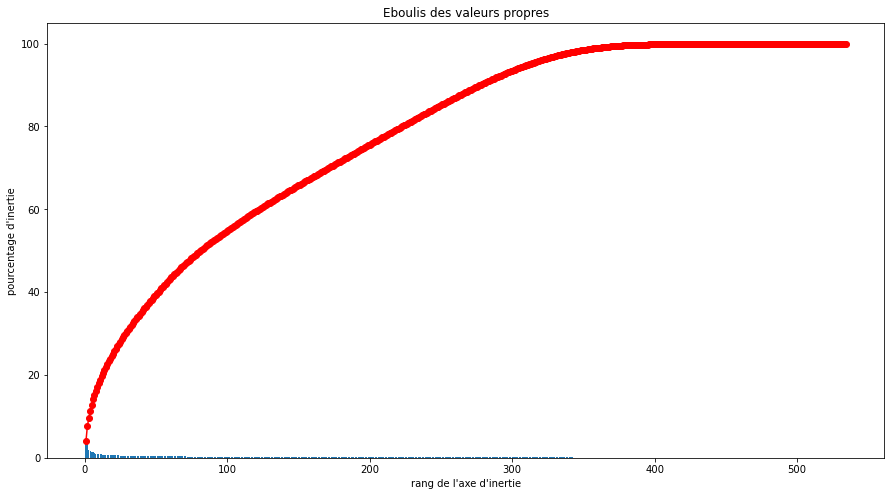

In [5]:
# Eboulis des valeurs propres
def display_scree_plot(pca):
    plt.figure(figsize=(15, 8))
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)
display_scree_plot(pca)

In [6]:
# Determination du nombre de composantes ayant un pouvoir explicatif acceptable
# je garderai les variables qui permettent d'expliquer 99% de mon modèle finale
from sklearn import decomposition
pca = decomposition.PCA(n_components=0.99)
feat_pca = pca.fit_transform(X_scaled)
print(pca.explained_variance_ratio_.sum())
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

0.9901389400447602
Dimensions dataset après réduction PCA :  (307507, 361)


# Modelisation

## Sampling des données

In [3]:
# échantillonnage de mon jeu de données
# je travaille avec 10% de mon jeu de données
from sklearn.utils import resample
df_sample = resample(df, n_samples= 30000, replace=False,random_state=42)
# controle des poids après echantillonnage
print(df['TARGET'].value_counts(normalize = True),df_sample['TARGET'].value_counts(normalize = True))

0.0    0.91927
1.0    0.08073
Name: TARGET, dtype: float64 0.0    0.917933
1.0    0.082067
Name: TARGET, dtype: float64


In [34]:
# Creation du train et test split
from sklearn.model_selection import train_test_split
X = df_sample.drop(columns =['TARGET'])
y = df_sample['TARGET']
X_train_1, X_test_1, y_train, y_test = train_test_split(X, y,test_size=0.3,stratify=y, random_state=42)
X_train = X_train_1.drop(columns= ['SK_ID_CURR'])
X_test = X_test_1.drop(columns= ['SK_ID_CURR'])
print("X_train shape: {}, X_test shape: {},y_train shape: {}, y_test shape: {}".format(X_train.shape, X_test.shape,y_train.shape, y_test.shape))

X_train shape: (21000, 533), X_test shape: (9000, 533),y_train shape: (21000,), y_test shape: (9000,)


## implementation du meilleur modèle

In [12]:
# Selection des modèles qui vont etre entrainés en utilsant la technique classweight pour gerer le désequilibre

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier 
from sklearn.svm import SVC
from sklearn.ensemble import  RandomForestClassifier 
from xgboost import XGBClassifier 
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from collections import Counter
from time import time

# Initialisation de la pipeline des modeles

pipeline_dummy = Pipeline(
    [('standard_scaler', StandardScaler()),('pca', decomposition.PCA(n_components=0.99)), ('Dummy', DummyClassifier(random_state=42))])
pipeline_logistic = Pipeline(
    [('standard_scaler', StandardScaler()),('pca', decomposition.PCA(n_components=0.99)), ('Logistic', LogisticRegression(class_weight='balanced',random_state=42))])
pipeline_RandomForestClf = Pipeline(
    [('standard_scaler', StandardScaler()),('pca', decomposition.PCA(n_components=0.99)), ('RFC', RandomForestClassifier(class_weight='balanced',random_state=42))])
pipeline_LightGBM = Pipeline(
    [('standard_scaler', StandardScaler()),('pca', decomposition.PCA(n_components=0.99)), ('LightGBM', LGBMClassifier(class_weight= "balanced", random_state=42))])


# initialisation des hyperparametres

Param_Dummy = {'Dummy__strategy': ['most_frequent', 'prior', 'stratified', 'uniform', 'constant']}

Param_Logistic = {'Logistic__C': np.logspace(-3, 3, 7),
                  'Logistic__penalty':['l1','l2','elasticnet'],
                  'Logistic__solver':['liblinear','newton-cg', 'lbfgs', 'sag', 'saga'] 
                 }


Param_RandomForestClf = {'RFC__max_depth' : [4,5,10,50],
                         'RFC__min_samples_split': [2, 5, 10],
                         'RFC__min_samples_leaf': [1, 2, 4],
                         'RFC__n_estimators': [100],
                         'RFC__max_leaf_nodes': [10,50]
                        }

Param_LightGBM = {'LightGBM__boosting_type':['gbdt','rf','dart','goss'],
                 'LightGBM__n_estimators':[50,100],
                 'LightGBM__learning_rate': [0.01,0.1, 0.2],
                 'LightGBM__num_leaves':[30],
                 'LightGBM__max_depth':[5,8,10],
                 'LightGBM__min_split_gain':[0.01,0.1, 0.2],  
                 }

# Definition de mes mesures de performances du modele
scorers = {
    "auc": "roc_auc",
    "f1" : "f1"
}


# Initialisation de mes GridSearchCV et utilisation de l'AUC
# indiquer le nombre de crossvalidation
cv = 5
Grid_Dummy = GridSearchCV(pipeline_dummy, Param_Dummy, cv=cv, scoring=scorers, refit = "auc")
Grid_Logistic = GridSearchCV(pipeline_logistic, Param_Logistic, cv=cv, scoring=scorers, refit = "auc")
Grid_RandomForestClf = GridSearchCV(pipeline_RandomForestClf, Param_RandomForestClf, cv=cv, scoring=scorers, refit = "auc")
GridLightGBM = GridSearchCV(pipeline_LightGBM,Param_LightGBM, cv=cv, scoring=scorers, refit = "auc")

# Creation de la liste des Grid
Grids = [Grid_Logistic,Grid_RandomForestClf,Grid_Dummy,GridLightGBM]

In [13]:
# Modélisation avec mes différents modèles
Grids = [Grid_Dummy,Grid_Logistic,Grid_RandomForestClf, 
         GridLightGBM]
grid_dict = {0: 'dummyClf',
             1: 'Logistic',
             2: 'RandomForestClf',
             3: 'LightGBM'
             }

tab = pd.DataFrame(columns=['AUC_validation_set', 'F1_validation_set', 'mean_fit_time', 'predict_time', 'params', 'split0_AUC_score', 'split1_AUC_score',
                            'split2_AUC_score', 'split3_AUC_score', 'split4_AUC_score'])
# Fit the grid search objects
print('Performing model optimizations...')
for idx, gs in enumerate(Grids):
    print('\nEstimator: %s' % grid_dict[idx])
    # Condition pour le lightGBM
    if grid_dict[idx] == 'LightGBM':
        gs.fit(X_train.to_numpy(), y_train.to_numpy())
        # creation de la grille des resultats
        Grille = pd.DataFrame(gs.cv_results_)
        z = pd.DataFrame(Grille, index=[gs.best_index_])
        # temps pour predire
        start = time()
        clf_probs = gs.predict_proba(X_test.to_numpy())
        predict_time = time()-start
    else:
        # fit pour les autres modeles hors LightGBM
        gs.fit(X_train, y_train)
        # creation de la grille des resultats
        Grille = pd.DataFrame(gs.cv_results_)
        z = pd.DataFrame(Grille, index=[gs.best_index_])
        # temps pour predire
        start = time()
        clf_probs = gs.predict_proba(X_test)
        predict_time = time()-start
    # creation de mon dictionnaire
    Grille_comparaison = {"AUC_validation_set": list(z["mean_test_auc"]),
                          "F1_validation_set": list(z["mean_test_f1"]),
                          "mean_fit_time": list(z["mean_fit_time"]),
                          "predict_time": predict_time,
                          "params": list(z["params"]),
                          "split0_AUC_score": list(z["split0_test_auc"]),
                          "split1_AUC_score": list(z["split1_test_auc"]),
                          "split2_AUC_score": list(z["split2_test_auc"]),
                          "split3_AUC_score": list(z["split3_test_auc"]),
                          "split4_AUC_score": list(z["split4_test_auc"]),
                          }

    grid_dict[idx] = pd.DataFrame(Grille_comparaison, index=[grid_dict[idx]])
    tab = tab.append(grid_dict[idx], ignore_index=False)

Performing model optimizations...

Estimator: dummyClf

Estimator: Logistic

Estimator: RandomForestClf

Estimator: LightGBM


In [14]:
# parametres du meilleur modele
tab.sort_values(by = "AUC_validation_set",ascending = False)

AUC_validation_set F1_validation_set mean_fit_time  \
Logistic                  0.745486          0.256723      2.329976   
LightGBM                  0.702629          0.246564      2.879833   
RandomForestClf           0.702239          0.228506     18.578893   
dummyClf                       0.5               0.0      1.214812   

                predict_time  \
Logistic            0.251512   
LightGBM            0.138491   
RandomForestClf     0.310918   
dummyClf            0.119153   

                                                            params  \
Logistic         {'Logistic__C': 0.001, 'Logistic__penalty': 'l...   
LightGBM         {'LightGBM__boosting_type': 'goss', 'LightGBM_...   
RandomForestClf  {'RFC__max_depth': 50, 'RFC__max_leaf_nodes': ...   
dummyClf                      {'Dummy__strategy': 'most_frequent'}   

                split0_AUC_score split1_AUC_score split2_AUC_score  \
Logistic                0.728399         0.757127         0.743944   
LightGBM                0.684008           0.7174         0.688717   
RandomForestClf         0.694032         0.720946          0.69238   
dummyClf                     0.5              0.5              0.5   

                split3_AUC_score split4_AUC_score  
Logistic                0.761672          0.73629  
LightGBM                 0.72623         0.696789  
RandomForestClf          0.71626         0.687579  
dummyClf                     0.5              0.5

In [16]:
Grid_Logistic.best_params_

{'Logistic__C': 0.001,
 'Logistic__penalty': 'l2',
 'Logistic__solver': 'liblinear'}

## Fine tuning du meilleur modèle

In [17]:
# Pipeline et parametre pour le meilleur modele selectionné
pipeline_logistic = Pipeline(
    [('standard_scaler', StandardScaler()),('pca', decomposition.PCA(n_components=0.99)), ('Logistic', LogisticRegression(class_weight='balanced',random_state=42))])

Param_Logistic = {'Logistic__C': [.0008,0.0009,0.001,0.002,0.003,0.004,0.005,0.006],
                  'Logistic__penalty':['l2'],
                  'Logistic__solver':['liblinear'] 
                 }

Grid_Logistic = GridSearchCV(pipeline_logistic, Param_Logistic, cv=cv, scoring=scorers, refit = "auc")
# Modelisation

Grid_Logistic.fit(X_train, y_train)
# Performance du modèle
print('Best params are : %s' % Grid_Logistic.best_params_)
print('Best training score: %.3f' % Grid_Logistic.best_score_)

Best params are : {'Logistic__C': 0.0008, 'Logistic__penalty': 'l2', 'Logistic__solver': 'liblinear'}
Best training score: 0.746


In [18]:
# enregistrement du meilleur modèle
filename = 'logistic_model_V1'
# some time later...
pickle.dump(Grid_Logistic, open(filename, 'wb'))

## Matrice de confusion

In [5]:
# Chargement du meilleur modèle
filename = 'logistic_model_V1'
loaded_model = pickle.load(open(filename, 'rb'))

              precision    recall  f1-score   support

         0.0       0.96      0.68      0.79      8261
         1.0       0.17      0.72      0.27       739

    accuracy                           0.68      9000
   macro avg       0.56      0.70      0.53      9000
weighted avg       0.90      0.68      0.75      9000



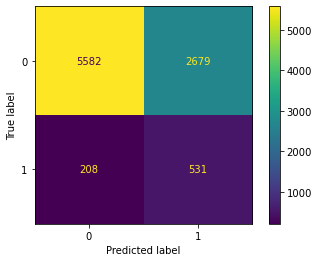

In [6]:
# Initialisation du modèle final
clf = loaded_model

# Matrice de confusion
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

# Print metrics: recall, precision and f1
print(classification_report(y_test, y_pred, output_dict=False))

## Metrique de classement 

- Les mesures de classement sont basées sur la façon dont le modèle classe les classes (le concept de séparabilité) 
- Zone sous la courbe de rappel de précision (PR AUC).
- Zone sous la courbe des caractéristiques de fonctionnement du récepteur (AUROC)

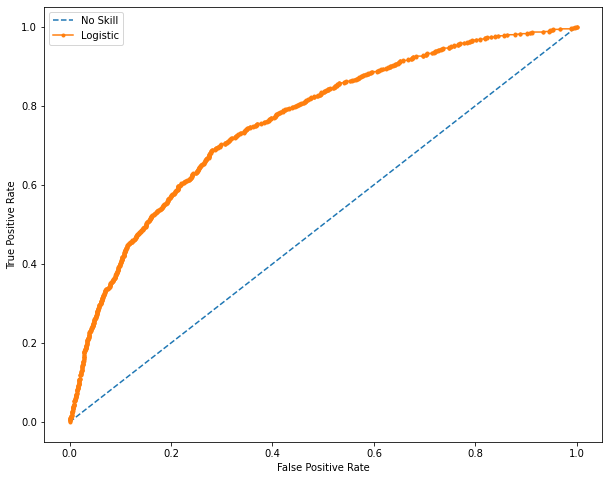

AUROC: 0.760


In [7]:
# Courbe de ROC
# La courbe ROC (Receiver Operator Characteristic)
# montre la relation entre le taux de vrai positif et le taux de faux positifs de notre classificateur.
plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')

# retrieve the probabilities for the positive class
yhat_positive = clf.predict_proba(X_test)[:, 1]

# calculate inputs for the roc curve
fpr, tpr, thresholds = roc_curve(y_test, yhat_positive)

# plot roc curve
plt.plot(fpr, tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
plt.show()

# calculate and print AUROC
roc_auc = roc_auc_score(y_test, yhat_positive)
print('AUROC: %.3f' % roc_auc)

## Fonction cout metier


In [8]:
import numpy as np
from sklearn.metrics import confusion_matrix

def custom_score(y_true, y_pred):
    # Relative loss and gains for each case
    TP_value = 0      
    FP_value = -1       
    FN_value = -10     
    TN_value = 0       

    # Confusion matrix
    (TN, FP, FN, TP) = confusion_matrix(y_true, y_pred).ravel()

    # Full negative and positive cases
    N = TN + FP # total true not-default
    P = TP + FN # total true default

    gain = TP*TP_value + TN*TN_value + FP*FP_value + FN*FN_value
    best = N*TN_value + P*TP_value
    baseline = N*TN_value + P*FN_value
    
    # normalize to get score between 0 (baseline) and 1
    score = (gain - baseline) / (best - baseline)
    return score


def predict_threshold(model, X, threshold=0.5):
    predictions = model.predict_proba(X)
    mask = (predictions[:, 1] > threshold)
    return mask.astype(int)


def custom_scorer(model, X, y_true):
    scores = []
    for threshold in np.linspace(0, 1, num=101):
        y_pred = predict_threshold(model, X, threshold=threshold)
        score = custom_score(y_true, y_pred)
        scores.append(score)
    # print(max(scores))
    return max(scores)

Max score: 0.3698240866035183
Optimal threshold: 0.53


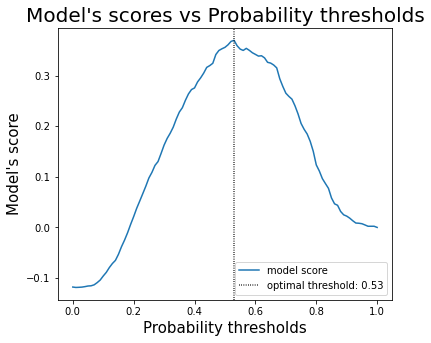

In [9]:
import numpy as np

scores = []
for threshold in np.linspace(0, 1, num=101):
    y_pred = predict_threshold(clf, X_test, threshold=threshold)
    score = custom_score(y_test, y_pred)
    scores.append(score)
fig, ax = plt.subplots(figsize=(6, 5))
plt.plot(np.linspace(0, 1, num=101), scores, label="model score")

max_score = max(scores)
opt_threshold = np.linspace(0, 1, num=101)[scores.index(max_score)]

plt.axvline(x=opt_threshold, color='k', dashes=(0.5, 1), label="optimal threshold: {}".format(opt_threshold))

plt.title("Model's scores vs Probability thresholds", fontsize=20)
plt.xlabel("Probability thresholds", fontsize=15)
plt.ylabel("Model's score", fontsize=15)
plt.legend()

print("Max score:", max_score)
print("Optimal threshold:", opt_threshold)

In [10]:
A = y_test.tolist()
B = y_pred.tolist()
C = yhat_positive.tolist()
Donnees_Test = pd.DataFrame(list(zip(A,B,C)), columns=['y_test', 'y_pred','y_predict_proba'])
Donnees_Test

y_test  y_pred  y_predict_proba
0        0.0       0         0.139247
1        0.0       0         0.121431
2        0.0       0         0.714902
3        0.0       0         0.256918
4        0.0       0         0.459589
...      ...     ...              ...
8995     0.0       0         0.189153
8996     1.0       0         0.937805
8997     0.0       0         0.565319
8998     0.0       0         0.575521
8999     0.0       0         0.200856

[9000 rows x 3 columns]

              precision    recall  f1-score   support

         0.0       0.96      0.72      0.83      8261
         1.0       0.18      0.68      0.28       739

    accuracy                           0.72      9000
   macro avg       0.57      0.70      0.56      9000
weighted avg       0.90      0.72      0.78      9000



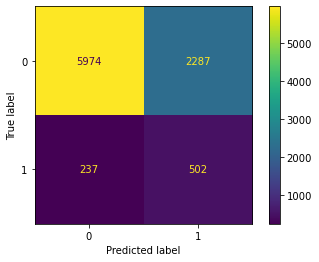

In [11]:
# Application du seuil et modification des labels
# https://kobia.fr/classification-metrics-f1-score/
# le nouveau seuil permet d'augmenter notre F1 score qui passe de 0.79 à 0.83
Donnees_Test['y_pred_thresh'] = np.where(Donnees_Test['y_predict_proba']> opt_threshold,1,0)

# Matrice de confusion
cm_thresh = confusion_matrix(Donnees_Test['y_test'], Donnees_Test['y_pred_thresh'])
cm_display_thresh = ConfusionMatrixDisplay(cm_thresh).plot()

# Print metrics: recall, precision and f1
print(classification_report(Donnees_Test['y_test'], Donnees_Test['y_pred_thresh'], output_dict=False))

# Feature importance

In [35]:
# je selectionne 100 valeurs pour des soucis de memoire
X_train_data_1 = shap.sample(X_train_1,100, random_state=0)
X_test_data_1 = shap.sample(X_test_1,100, random_state=0)
X_train_data = X_train_data_1.drop(columns=["SK_ID_CURR"])
X_test_data = X_test_data_1.drop(columns=["SK_ID_CURR"])
explainer = shap.KernelExplainer(clf.predict_proba, X_train_data)
shap_values = explainer.shap_values(X_test_data)

  0%|          | 0/100 [00:00<?, ?it/s]

In [36]:
#Sauvegarde de mas valeurs shap
filename = 'Shap_values_Dashboard_V1.pkl'
# some time later...
pickle.dump(shap_values, open(filename, 'wb'))

In [37]:
#Sauvegarde de mas valeurs X_test_data
filename = 'X_test_data_Dashboard_V1.pkl'
# some time later...
pickle.dump(X_test_data_1, open(filename, 'wb'))

## Feature importance global

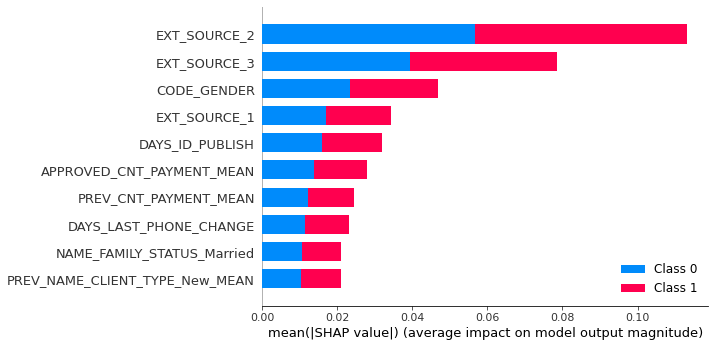

In [38]:
shap.initjs()
shap.summary_plot(shap_values, X_test_data, feature_names=X_test_data.columns, max_display=10)

## Feature importance local

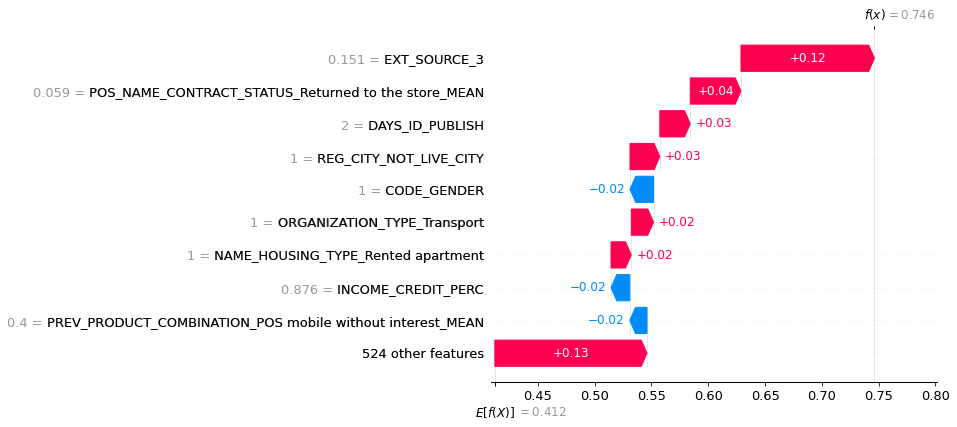

In [16]:
row = 9
shap.waterfall_plot(shap.Explanation(values=shap_values[1][row], 
                                              base_values=explainer.expected_value[1], data=X_test_data.iloc[row],  
                                         feature_names=X_test_data.columns.tolist()))

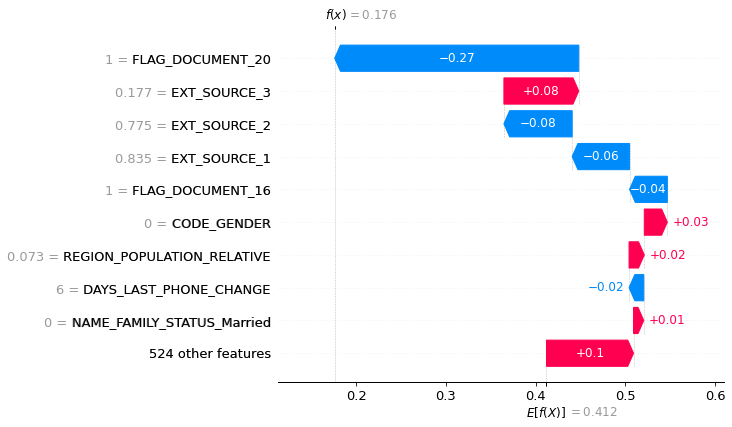

In [17]:
row = 1
shap.waterfall_plot(shap.Explanation(values=shap_values[1][row], 
                                              base_values=explainer.expected_value[1], data=X_test_data.iloc[row],  
                                         feature_names=X_test_data.columns.tolist()))

https://www.youtube.com/watch?v=OORmAOklRJA